# World Data League 2023

## 🎯 Challenge
Determining The Main Mobility Flows in the City of Lisbon Based on Mobile Device Data


## Team: Data Warriors
## 👥 Authors
* Clara Pedroso
* Gonçalo Ferreira
* João Anacleto
* Madalena Diniz

## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters. More specifically, don't forget to explore the following:
1. Assess the data quality
2. Make sure you have a good EDA where you enlist all the insights
3. Explain the process for feature engineering and cleaning
4. Discuss the model / technique(s) selection
5. Don't forget to explore model interpretability and fairness or justify why it is not needed

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

Pro-tip 3: Don't forget to have a motivate all of your choices, these can be: Data-driven, constraints-driven, literature-driven or a combination of any. For example, why did you choose to test certain algorithms or why only one.

###<font color='#BFD724'> 0. Data Importation

#####<font color='#BFD724'> Importing Libraries and packages

In [1]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install pandas scikit-learn

import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from rtree import Index
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_absolute_error, mean_squared_error


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 340 kB of archives.
After this operation, 1,538 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex6 amd64 1.9.3-1build1 [266 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-c6 amd64 1.9.3-1build1 [58.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-dev amd64 1.9.3-1build1 [16.0 kB]
Fetched 340 kB in 0s (874 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-1b

#####<font color='#BFD724'> Importing Datasets

Definition of a working directory and opening the datasets related with smartphones tracked in Lisbon from October to November.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importation of the datasets.

In [3]:
#tele_ativos_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/tele_ativos_por200x200_15min_Set.csv')
#tele_ativos_out = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/tele_ativos_por200x200_15min_Out.csv')
#tele_ativos_nov = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/tele_ativos_por200x200_15min_Nov.csv')

In [4]:
waze_set_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze1.csv')
waze_set_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze2.csv')
waze_set_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze3.csv')
waze_set_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze4.csv')

waze_out_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_out_waze1.csv')
waze_out_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_out_waze2.csv')

waze_nov_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze1.csv')
waze_nov_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze2.csv')
waze_nov_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze3.csv')

In [5]:
condicionamentos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv')
dataset3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/entrada_saida_mainRoads_15min.csv')

#####<font color='#BFD724'> External Sources

This is a csv file with weather data of Lisbon from Sep 2022 until Nov 2022.

In [6]:
meteo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/weather_hourly.csv')

This is a zip file from external sources, containing a shapefile with all "Freguesias" from Portugal.

In [49]:
# specify the path to the shapefile (without the file extension)
path_to_shapefile = "/content/drive/MyDrive/Colab Notebooks/Case Study/data/Freguesias2020"

# read the shapefile using GeoPandas
data = gpd.read_file(path_to_shapefile)

###<font color='#BFD724'> 1. Pre processing


Pre-processing Steps:
1.  Check for duplicated rows
2.  Check for missing values
3.  Check the outliers
4.  Treat everything

#### "tele_ativos" Datasets

In this chapter we will execute the Pre-processing of the following datasets:
1. tele_ativos_por200x200_15min_Nov.csv
2. tele_ativos_por200x200_15min_Out.csv
3. tele_ativos_por200x200_15min_Set.csv

#####<font color='#BFD724'> 1. Duplicates

After a brief analysis we not found any duplicated rows in the datasets.

In [ ]:
tele_ativos_set[tele_ativos_set.duplicated(keep=False)]

In [ ]:
tele_ativos_out[tele_ativos_out.duplicated(keep=False)]

In [ ]:
tele_ativos_nov[tele_ativos_nov.duplicated(keep=False)]

#####<font color='#BFD724'> 2. Missing values

We were able to conclude that we dont have any sort of missing values in this dataset.

In [ ]:
tele_ativos_set.isna().sum()/len(tele_ativos_set)*100

In [ ]:
tele_ativos_out.isna().sum()/len(tele_ativos_out)*100

In [ ]:
tele_ativos_out.isna().sum()/len(tele_ativos_out)*100

#####<font color='#BFD724'> 3. Outliers

We have identified some possible outliers candidates so we proceed to treat them.

In [ ]:
tele_ativos_set_outliers = tele_ativos_set[["Grid_ID",	"C1",	"C2",	"C3",	"C4",	"C5",	"C6",	"C7",	"C8"]]

for col in tele_ativos_set_outliers:
    fig= sns.boxplot(x=col, data = tele_ativos_set_outliers)
    plt.show()

In [ ]:
tele_ativos_out_outliers = tele_ativos_out[["Grid_ID",	"C1",	"C2",	"C3",	"C4",	"C5",	"C6",	"C7",	"C8"]]

for col in tele_ativos_out_outliers:
    fig= sns.boxplot(x=col, data = tele_ativos_out_outliers)
    plt.show()

In [ ]:
tele_ativos_nov_outliers = tele_ativos_nov[["Grid_ID",	"C1",	"C2",	"C3",	"C4",	"C5",	"C6",	"C7",	"C8"]]

for col in tele_ativos_nov_outliers:
    fig= sns.boxplot(x=col, data = tele_ativos_nov_outliers)
    plt.show()

#####<font color='#BFD724'> 4. Treating everything

In [ ]:
for col in tele_ativos_set_outliers:

    upper_limit = round(tele_ativos_set_outliers[col].mean() + 3*tele_ativos_set_outliers[col].std(),2)
    lower_limit = round(tele_ativos_set_outliers[col].mean() - 3*tele_ativos_set_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (tele_ativos_set_outliers[col] > upper_limit).sum() + (tele_ativos_set_outliers[col] < lower_limit).sum()))

    tele_ativos_set_outliers[col] = np.where(tele_ativos_set_outliers[col] > upper_limit, upper_limit,
         np.where(tele_ativos_set_outliers[col] < lower_limit,lower_limit,tele_ativos_set_outliers[col]))

In [ ]:
for col in tele_ativos_out_outliers:

    upper_limit = round(tele_ativos_out_outliers[col].mean() + 3*tele_ativos_out_outliers[col].std(),2)
    lower_limit = round(tele_ativos_out_outliers[col].mean() - 3*tele_ativos_out_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (tele_ativos_out_outliers[col] > upper_limit).sum() + (tele_ativos_out_outliers[col] < lower_limit).sum()))

    tele_ativos_out_outliers[col] = np.where(tele_ativos_out_outliers[col] > upper_limit, upper_limit,
         np.where(tele_ativos_out_outliers[col] < lower_limit,lower_limit,tele_ativos_out_outliers[col]))

In [ ]:
for col in tele_ativos_nov_outliers:

    upper_limit = round(tele_ativos_nov_outliers[col].mean() + 3*tele_ativos_nov_outliers[col].std(),2)
    lower_limit = round(tele_ativos_nov_outliers[col].mean() - 3*tele_ativos_nov_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (tele_ativos_nov_outliers[col] > upper_limit).sum() + (tele_ativos_nov_outliers[col] < lower_limit).sum()))

    tele_ativos_nov_outliers[col] = np.where(tele_ativos_nov_outliers[col] > upper_limit, upper_limit,
         np.where(tele_ativos_nov_outliers[col] < lower_limit,lower_limit,tele_ativos_nov_outliers[col]))

In [ ]:
for col in tele_ativos_set_outliers:
    fig= sns.boxplot(x=col, data = tele_ativos_set_outliers)
    plt.show()

Divide the collumn data time 

In [ ]:
print(tele_ativos_nov.dtypes)

In [ ]:
tele_ativos_set['Datetime'] = pd.to_datetime(tele_ativos_set['Datetime'])

# create new columns for date and time
tele_ativos_set['date'] = tele_ativos_set['Datetime'].dt.date
tele_ativos_set['time'] = tele_ativos_set['Datetime'].dt.time

# drop the original 'datetime' column
tele_ativos_set.drop('Datetime', axis=1, inplace=True)

# print the updated DataFrame
tele_ativos_set.head()

In [ ]:
tele_ativos_out['Datetime'] = pd.to_datetime(tele_ativos_out['Datetime'])

# create new columns for date and time
tele_ativos_out['date'] = tele_ativos_out['Datetime'].dt.date
tele_ativos_out['time'] = tele_ativos_out['Datetime'].dt.time

# drop the original 'datetime' column
tele_ativos_out.drop('Datetime', axis=1, inplace=True)

# print the updated DataFrame
tele_ativos_out.head()

In [ ]:
tele_ativos_nov['Datetime'] = pd.to_datetime(tele_ativos_nov['Datetime'])

# create new columns for date and time
tele_ativos_nov['date'] = tele_ativos_nov['Datetime'].dt.date
tele_ativos_nov['time'] = tele_ativos_nov['Datetime'].dt.time

# drop the original 'datetime' column
tele_ativos_nov.drop('Datetime', axis=1, inplace=True)

# print the updated DataFrame
tele_ativos_nov.head()

#### "transito_waze" Datasets

In this chapter we will execute the Pre-processing of the following datasets:
1. transito_set_waze1.csv
2. transito_set_waze2.csv
3. transito_set_waze3.csv
4. transito_set_waze4.csv


5. transito_out_waze1.csv
6. transito_out_waze2.csv


7. transito_nov_waze1.csv
8. transito_nov_waze1.csv
9. transito_nov_waze1.csv

#####<font color='#BFD724'> 1. Duplicates

No duplicated values were found in any of the datasets.

In [8]:
waze_set_1[waze_set_1.duplicated(keep=False)]
waze_set_2[waze_set_2.duplicated(keep=False)]
waze_set_3[waze_set_3.duplicated(keep=False)]
waze_set_4[waze_set_4.duplicated(keep=False)]

,entity_ts,entity_id,street,position,level,length,delay,speed


In [9]:
waze_out_1[waze_out_1.duplicated(keep=False)]
waze_out_2[waze_out_2.duplicated(keep=False)]

,entity_ts,entity_id,street,position,level,length,delay,speed


In [10]:
waze_nov_1[waze_nov_1.duplicated(keep=False)]
waze_nov_2[waze_nov_2.duplicated(keep=False)]
waze_nov_3[waze_nov_3.duplicated(keep=False)]

,entity_ts,entity_id,street,position,level,length,delay,speed


#####<font color='#BFD724'> 2. Missing values


All of them have missing values in the "street" column. We will only need the "position" column do determine the coordinates. With that said, we should delete the "street" column.

The ones that have other missing values are very few rows so we should delete those rows, always making sure that no more than 3% of the dataset is being deleted.

In [11]:
waze_set_1.isna().sum()/len(waze_set_1)*100

entity_ts     0.000000
entity_id     0.000000
street       19.523236
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

In [12]:
waze_set_2.isna().sum()/len(waze_set_2)*100

entity_ts     0.000000
entity_id     0.000000
street       18.588915
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

In [13]:
waze_set_3.isna().sum()/len(waze_set_3)*100

entity_ts     0.000000
entity_id     0.000000
street       16.545301
position      0.003366
level         0.003366
length        0.003366
delay         0.003366
speed         0.000000
dtype: float64

In [14]:
waze_set_4.isna().sum()/len(waze_set_4)*100

entity_ts     0.000000
entity_id     0.000000
street       16.180494
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

In [15]:
waze_out_1.isna().sum()/len(waze_out_1)*100

entity_ts     0.000000
entity_id     0.000000
street       17.860661
position      0.020807
level         0.020807
length        0.020807
delay         0.020807
speed         0.000000
dtype: float64

In [16]:
waze_out_2.isna().sum()/len(waze_out_2)*100

entity_ts     0.000000
entity_id     0.000000
street       23.618436
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

In [17]:
waze_nov_1.isna().sum()/len(waze_nov_1)*100

entity_ts     0.000000
entity_id     0.000000
street       20.345363
position      0.000658
level         0.000658
length        0.000658
delay         0.000658
speed         0.000000
dtype: float64

In [18]:
waze_nov_2.isna().sum()/len(waze_nov_2)*100

entity_ts     0.000000
entity_id     0.000000
street       18.470328
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

In [19]:
waze_nov_3.isna().sum()/len(waze_nov_3)*100

entity_ts     0.000000
entity_id     0.000000
street       18.061759
position      0.000000
level         0.000000
length        0.000000
delay         0.000000
speed         0.000000
dtype: float64

#####<font color='#BFD724'> 3. Outliers

After checking some of the datasets it is visible that there are some outliers so we will have to treat them as well.

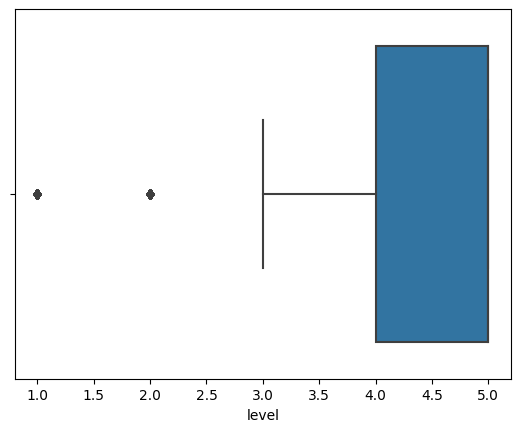

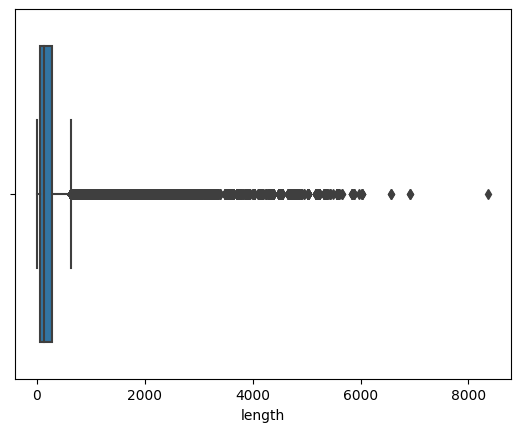

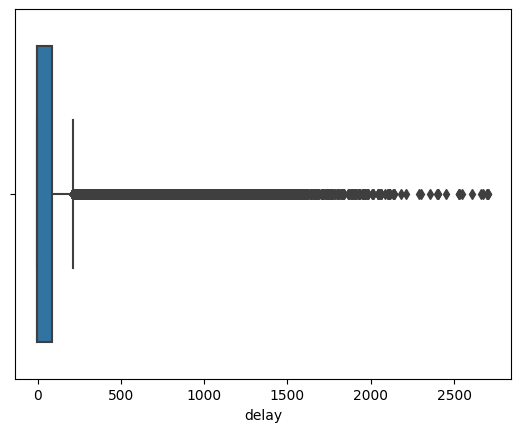

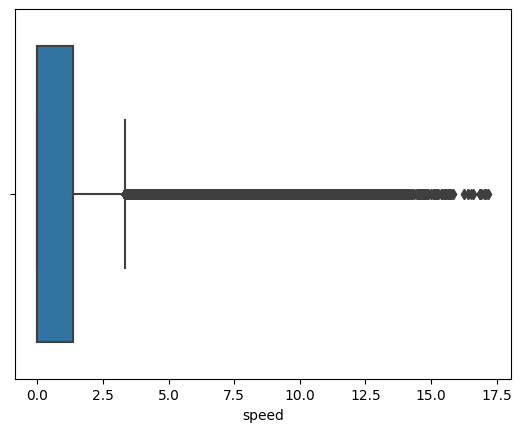

In [20]:
waze_set_1_num = waze_set_1[['level', 'length', 'delay', 'speed']]

for col in waze_set_1_num:
    fig= sns.boxplot(x=col, data = waze_set_1_num)
    plt.show()

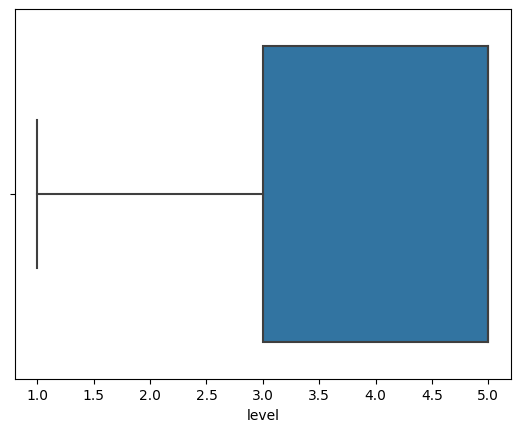

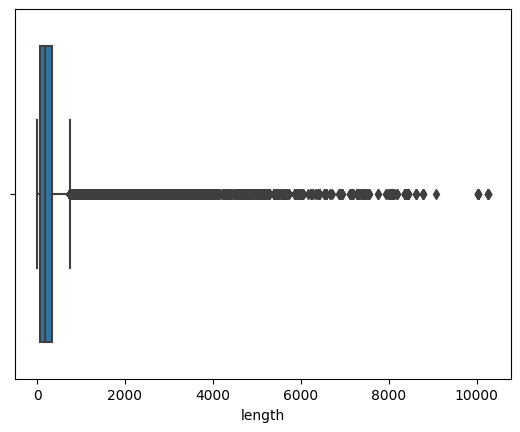

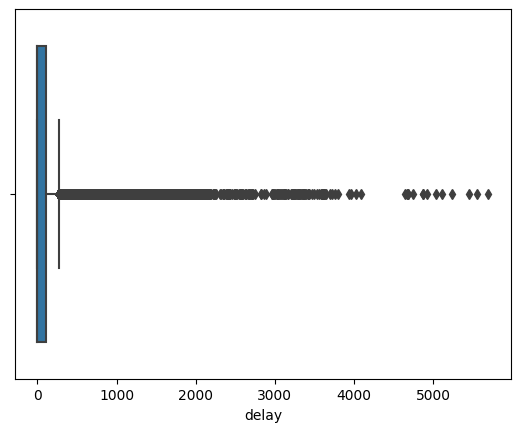

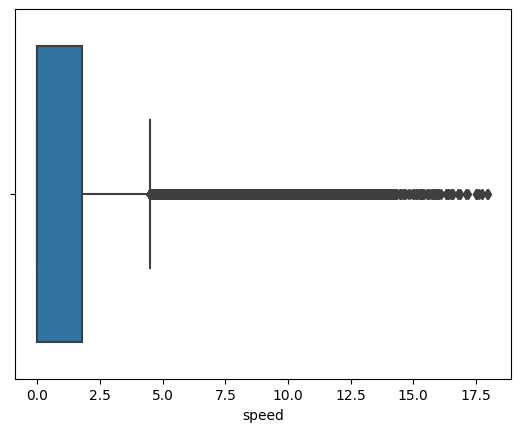

In [21]:
waze_out_1_num = waze_out_1[['level', 'length', 'delay', 'speed']]

for col in waze_out_1_num:
    fig= sns.boxplot(x=col, data = waze_out_1_num)
    plt.show()

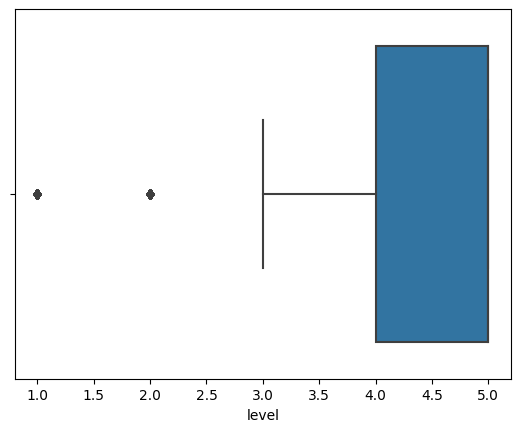

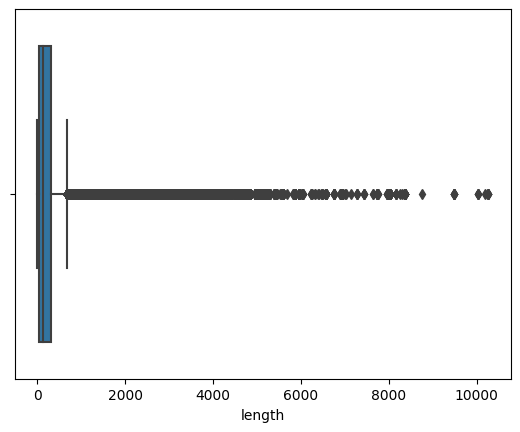

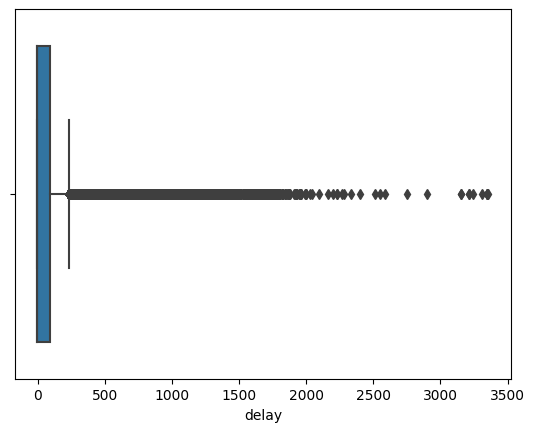

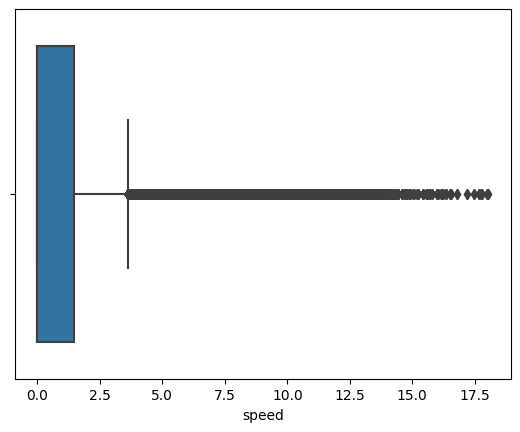

In [22]:
waze_nov_1_num = waze_nov_1[['level', 'length', 'delay', 'speed']]

for col in waze_nov_1_num:
    fig= sns.boxplot(x=col, data = waze_nov_1_num)
    plt.show()

#####<font color='#BFD724'> 4. Treating everything

1st. We will delete the "street" column since it has many missing values

In [23]:
waze_set_1.drop(labels = ['street'], axis = 1, inplace = True)
waze_set_2.drop(labels = ['street'], axis = 1, inplace = True)
waze_set_3.drop(labels = ['street'], axis = 1, inplace = True)
waze_set_4.drop(labels = ['street'], axis = 1, inplace = True)

waze_out_1.drop(labels = ['street'], axis = 1, inplace = True)
waze_out_2.drop(labels = ['street'], axis = 1, inplace = True)

waze_nov_1.drop(labels = ['street'], axis = 1, inplace = True)
waze_nov_2.drop(labels = ['street'], axis = 1, inplace = True)
waze_nov_3.drop(labels = ['street'], axis = 1, inplace = True)

2nd. We will delete the rows containing missing values

In [24]:
waze_set_1.dropna(inplace = True)
waze_set_2.dropna(inplace = True)
waze_set_3.dropna(inplace = True)
waze_set_4.dropna(inplace = True)

waze_out_1.dropna(inplace = True)
waze_out_2.dropna(inplace = True)

waze_nov_1.dropna(inplace = True)
waze_nov_2.dropna(inplace = True)
waze_nov_3.dropna(inplace = True)

3rd. We will treat the outliers by setting a barrier, thus modifying its values, but only for the numerical columns ("level", "length", "delay" and "speed")

In [25]:
waze_set_1_outliers = waze_set_1[['level', 'length', 'delay', 'speed']]
waze_set_2_outliers = waze_set_2[['level', 'length', 'delay', 'speed']]
waze_set_3_outliers = waze_set_3[['level', 'length', 'delay', 'speed']]
waze_set_4_outliers = waze_set_4[['level', 'length', 'delay', 'speed']]

waze_out_1_outliers = waze_out_1[['level', 'length', 'delay', 'speed']]
waze_out_2_outliers = waze_out_2[['level', 'length', 'delay', 'speed']]

waze_nov_1_outliers = waze_nov_1[['level', 'length', 'delay', 'speed']]
waze_nov_2_outliers = waze_nov_2[['level', 'length', 'delay', 'speed']]
waze_nov_3_outliers = waze_nov_3[['level', 'length', 'delay', 'speed']]

In [26]:
for col in waze_set_1_outliers:

    upper_limit = round(waze_set_1_outliers[col].mean() + 3*waze_set_1_outliers[col].std(),2)
    lower_limit = round(waze_set_1_outliers[col].mean() - 3*waze_set_1_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_set_1_outliers[col] > upper_limit).sum() + (waze_set_1_outliers[col] < lower_limit).sum()))

    waze_set_1_outliers[col] = np.where(waze_set_1_outliers[col] > upper_limit, upper_limit,
         np.where(waze_set_1_outliers[col] < lower_limit,lower_limit,waze_set_1_outliers[col]))

Affected rows in level: 4347
Affected rows in length: 10790
Affected rows in delay: 11423
Affected rows in speed: 11530


<ipython-input-26-9d21bc6f6c51>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_set_1_outliers[col] = np.where(waze_set_1_outliers[col] > upper_limit, upper_limit,


In [27]:
for col in waze_set_2_outliers:

    upper_limit = round(waze_set_2_outliers[col].mean() + 3*waze_set_2_outliers[col].std(),2)
    lower_limit = round(waze_set_2_outliers[col].mean() - 3*waze_set_2_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_set_2_outliers[col] > upper_limit).sum() + (waze_set_2_outliers[col] < lower_limit).sum()))

    waze_set_2_outliers[col] = np.where(waze_set_2_outliers[col] > upper_limit, upper_limit,
         np.where(waze_set_2_outliers[col] < lower_limit,lower_limit,waze_set_2_outliers[col]))

Affected rows in level: 6536
Affected rows in length: 12409


<ipython-input-27-7b919e74be70>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_set_2_outliers[col] = np.where(waze_set_2_outliers[col] > upper_limit, upper_limit,


Affected rows in delay: 10078
Affected rows in speed: 12320


In [28]:
for col in waze_set_3_outliers:

    upper_limit = round(waze_set_3_outliers[col].mean() + 3*waze_set_3_outliers[col].std(),2)
    lower_limit = round(waze_set_3_outliers[col].mean() - 3*waze_set_3_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_set_3_outliers[col] > upper_limit).sum() + (waze_set_3_outliers[col] < lower_limit).sum()))

    waze_set_3_outliers[col] = np.where(waze_set_3_outliers[col] > upper_limit, upper_limit,
         np.where(waze_set_3_outliers[col] < lower_limit,lower_limit,waze_set_3_outliers[col]))

Affected rows in level: 4147
Affected rows in length: 7907


<ipython-input-28-4f3f419e10f4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_set_3_outliers[col] = np.where(waze_set_3_outliers[col] > upper_limit, upper_limit,


Affected rows in delay: 8357
Affected rows in speed: 8541


In [29]:
for col in waze_set_4_outliers:

    upper_limit = round(waze_set_4_outliers[col].mean() + 3*waze_set_4_outliers[col].std(),2)
    lower_limit = round(waze_set_4_outliers[col].mean() - 3*waze_set_4_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_set_4_outliers[col] > upper_limit).sum() + (waze_set_4_outliers[col] < lower_limit).sum()))

    waze_set_4_outliers[col] = np.where(waze_set_4_outliers[col] > upper_limit, upper_limit,
         np.where(waze_set_4_outliers[col] < lower_limit,lower_limit,waze_set_4_outliers[col]))

Affected rows in level: 0
Affected rows in length: 5373
Affected rows in delay: 5170
Affected rows in speed: 5689


<ipython-input-29-a623813fef22>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_set_4_outliers[col] = np.where(waze_set_4_outliers[col] > upper_limit, upper_limit,


In [30]:
for col in waze_out_1_outliers:

    upper_limit = round(waze_out_1_outliers[col].mean() + 3*waze_out_1_outliers[col].std(),2)
    lower_limit = round(waze_out_1_outliers[col].mean() - 3*waze_out_1_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_out_1_outliers[col] > upper_limit).sum() + (waze_out_1_outliers[col] < lower_limit).sum()))

    waze_out_1_outliers[col] = np.where(waze_out_1_outliers[col] > upper_limit, upper_limit,
         np.where(waze_out_1_outliers[col] < lower_limit,lower_limit,waze_out_1_outliers[col]))

Affected rows in level: 0
Affected rows in length: 8151
Affected rows in delay: 9090


<ipython-input-30-dfc2f12ba724>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_out_1_outliers[col] = np.where(waze_out_1_outliers[col] > upper_limit, upper_limit,


Affected rows in speed: 8704


In [31]:
for col in waze_out_2_outliers:

    upper_limit = round(waze_out_2_outliers[col].mean() + 3*waze_out_2_outliers[col].std(),2)
    lower_limit = round(waze_out_2_outliers[col].mean() - 3*waze_out_2_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_out_2_outliers[col] > upper_limit).sum() + (waze_out_2_outliers[col] < lower_limit).sum()))

    waze_out_2_outliers[col] = np.where(waze_out_2_outliers[col] > upper_limit, upper_limit,
         np.where(waze_out_2_outliers[col] < lower_limit,lower_limit,waze_out_2_outliers[col]))

Affected rows in level: 3446
Affected rows in length: 5448
Affected rows in delay: 6595


<ipython-input-31-4d9271e63c0d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_out_2_outliers[col] = np.where(waze_out_2_outliers[col] > upper_limit, upper_limit,


Affected rows in speed: 6142


In [32]:
for col in waze_nov_1_outliers:

    upper_limit = round(waze_nov_1_outliers[col].mean() + 3*waze_nov_1_outliers[col].std(),2)
    lower_limit = round(waze_nov_1_outliers[col].mean() - 3*waze_nov_1_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_nov_1_outliers[col] > upper_limit).sum() + (waze_nov_1_outliers[col] < lower_limit).sum()))

    waze_nov_1_outliers[col] = np.where(waze_nov_1_outliers[col] > upper_limit, upper_limit,
         np.where(waze_nov_1_outliers[col] < lower_limit,lower_limit,waze_nov_1_outliers[col]))

Affected rows in level: 4813
Affected rows in length: 8367


<ipython-input-32-1da979d68b1c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_nov_1_outliers[col] = np.where(waze_nov_1_outliers[col] > upper_limit, upper_limit,


Affected rows in delay: 11114
Affected rows in speed: 10371


In [33]:
for col in waze_nov_2_outliers:

    upper_limit = round(waze_nov_2_outliers[col].mean() + 3*waze_nov_2_outliers[col].std(),2)
    lower_limit = round(waze_nov_2_outliers[col].mean() - 3*waze_nov_2_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_nov_2_outliers[col] > upper_limit).sum() + (waze_nov_2_outliers[col] < lower_limit).sum()))

    waze_nov_2_outliers[col] = np.where(waze_nov_2_outliers[col] > upper_limit, upper_limit,
         np.where(waze_nov_2_outliers[col] < lower_limit,lower_limit,waze_nov_2_outliers[col]))

Affected rows in level: 0
Affected rows in length: 5978
Affected rows in delay: 7359


<ipython-input-33-c03e4e043d52>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_nov_2_outliers[col] = np.where(waze_nov_2_outliers[col] > upper_limit, upper_limit,


Affected rows in speed: 6799


In [34]:
for col in waze_nov_3_outliers:

    upper_limit = round(waze_nov_3_outliers[col].mean() + 3*waze_nov_3_outliers[col].std(),2)
    lower_limit = round(waze_nov_3_outliers[col].mean() - 3*waze_nov_3_outliers[col].std(),2)

    print('Affected rows in '+col+': '+str( (waze_nov_3_outliers[col] > upper_limit).sum() + (waze_nov_3_outliers[col] < lower_limit).sum()))

    waze_nov_3_outliers[col] = np.where(waze_nov_3_outliers[col] > upper_limit, upper_limit,
         np.where(waze_nov_3_outliers[col] < lower_limit,lower_limit,waze_nov_3_outliers[col]))

Affected rows in level: 0
Affected rows in length: 5462
Affected rows in delay: 6368
Affected rows in speed: 5965


<ipython-input-34-54b0c0fe23a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waze_nov_3_outliers[col] = np.where(waze_nov_3_outliers[col] > upper_limit, upper_limit,


Making a copy of the datasets

In [35]:
transito_set1 = waze_set_1.copy()
transito_set2 = waze_set_2.copy()
transito_set3 = waze_set_3.copy()
transito_set4 = waze_set_4.copy()

transito_out1 = waze_out_1.copy()
transito_out2 = waze_out_2.copy()

transito_nov1 = waze_nov_1.copy()
transito_nov2 = waze_nov_2.copy()
transito_nov3 = waze_nov_3.copy()

#### "weather_hourly" Dataset

In this chapter we will adjust the following dataset to this project:
1. weather_hourly.csv

In [36]:
# starting with copying the dataset so that we dont change the original
weather = meteo.copy()
weather.head(10)

,location,Basel,Basel.1,Basel.2,Basel.3,Basel.4
0,lat,47.75000,47.75000,47.75000,47.75000,47.75000
1,lon,7.50000,7.50000,7.50000,7.50000,7.50000
2,asl,363.653,363.653,363.653,363.653,363.653
3,variable,Temperature,Precipitation Total,Wind Speed,Wind Direction,Sunshine Duration
4,unit,°C,mm,km/h,°,min
5,level,2 m elevation corrected,sfc,10 m,10 m,sfc
6,resolution,hourly,hourly,hourly,hourly,hourly
7,aggregation,None,None,None,None,None
8,timestamp,Basel Temperature [2 m elevation corrected],Basel Precipitation Total,Basel Wind Speed [10 m],Basel Wind Direction [10 m],Basel Sunshine Duration
9,20220901T0000,15.150246,0.0,4.452954,75.96376,0.0


In [37]:
# splitting the weather dataset into the info regarding the columns and the actual data
weather_split1 = weather.iloc[:9]
weather_split2 = weather.iloc[9:]

In [38]:
# we will only use this subset to rename the columns in weather_split2
weather_info = weather_split1.copy()

In [39]:
weather_hourly = weather_split2.copy()

In [40]:
# dropping unnecessary columns
# precipitation is always relevant and temperature could be interesting for the warmer months (beach)

weather_hourly.drop(['Basel.2', 'Basel.3', 'Basel.4'], axis=1, inplace=True)
weather_hourly.head()

,location,Basel,Basel.1
9,20220901T0000,15.150246,0.0
10,20220901T0100,14.950245,0.0
11,20220901T0200,14.600245,0.0
12,20220901T0300,14.040245,0.0
13,20220901T0400,14.050245,0.0


In [41]:
# renaming the other columns 
weather_hourly.rename(columns={'location': 'date','Basel': 'temperature', 'Basel.1': 'precipitation'}, inplace=True)
weather_hourly.head()

,date,temperature,precipitation
9,20220901T0000,15.150246,0.0
10,20220901T0100,14.950245,0.0
11,20220901T0200,14.600245,0.0
12,20220901T0300,14.040245,0.0
13,20220901T0400,14.050245,0.0


In [42]:
# rounding the temperature to the decimals
weather_hourly['temperature'] = weather_hourly['temperature'].astype(float)
weather_hourly['temperature'] = weather_hourly['temperature'].round(1)

# passing the precipitation to float type
weather_hourly['precipitation'] = weather_hourly['precipitation'].astype(float)

# and the final result of this dataset
weather_hourly.head(10)

,date,temperature,precipitation
9,20220901T0000,15.2,0.0
10,20220901T0100,15.0,0.0
11,20220901T0200,14.6,0.0
12,20220901T0300,14.0,0.0
13,20220901T0400,14.1,0.0
14,20220901T0500,14.1,0.0
15,20220901T0600,15.3,0.0
16,20220901T0700,16.8,0.0
17,20220901T0800,18.1,0.0
18,20220901T0900,19.5,0.0


#### "condicionamentos" Dataset

In this chapter we will adjust the following dataset to this project:
1. CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv.csv

In [43]:
condicionamentos.head()

,creation_date,entity_id,position,impacto,morada,motivo,periodos_condicionamentos,restricao_circulacao
0,2022-09-01T08:26:21.000Z,EMEL.condicionamentoTransito.COND-2022-5213-1,"{""type"":""GeometryCollection"",""geometries"":[{""c...",Pouco relevante,"Rua João Saraiva, n.º 4",OBRA - PASSEIO E ESTACION.,"[{""end_date"":""1664380800000"",""date_min"":""2022-...",Estreitamento de via
1,2022-09-01T08:38:55.000Z,EMEL.condicionamentoTransito.COND-2022-5214-A-1,"{""type"":""GeometryCollection"",""geometries"":[{""c...",Pouco relevante,"Travessa Henrique Cardoso, n.º 77",OBRA - PASSEIO E ESTACION.,"[{""end_date"":""1664380800000"",""date_min"":""2022-...",Estreitamento de via
2,2022-09-01T08:49:59.000Z,EMEL.condicionamentoTransito.COND-2022-5215-1,"{""type"":""GeometryCollection"",""geometries"":[{""c...",Relevante,"Rua Ernâni Lopes, {ambos os sentidos}",RESERVA DE ESTACIONAMENTO,"[{""end_date"":""1662498000000"",""date_min"":""2022-...",Estacionamento
3,2022-09-01T08:53:46.000Z,EMEL.condicionamentoTransito.COND-2022-2383-PA-12,"{""type"":""GeometryCollection"",""geometries"":[{""c...",Relevante,"Rua Almeida Brandão, 1| Calçada da Estrela, 75",BETONAGENS/CARGAS DESCARGAS,"[{""end_date"":""1665675000000"",""date_min"":""2022-...",Estreitamento de via
4,2022-09-01T08:54:54.000Z,EMEL.condicionamentoTransito.COND-2022-5216-1,"{""type"":""GeometryCollection"",""geometries"":[{""c...",Pouco relevante,"Av. da Ucrânia, Marvila",OBRA - PASSEIO E ESTACION.,"[{""end_date"":""1664470800000"",""date_min"":""2022-...",Estreitamento de via


In [44]:
# create a copy of the most relevant columns from the 'dataset2' DataFrame
traffic_jam = condicionamentos[['creation_date', 'impacto','position', 'periodos_condicionamentos']].copy()
traffic_jam.head()

,creation_date,impacto,position,periodos_condicionamentos
0,2022-09-01T08:26:21.000Z,Pouco relevante,"{""type"":""GeometryCollection"",""geometries"":[{""c...","[{""end_date"":""1664380800000"",""date_min"":""2022-..."
1,2022-09-01T08:38:55.000Z,Pouco relevante,"{""type"":""GeometryCollection"",""geometries"":[{""c...","[{""end_date"":""1664380800000"",""date_min"":""2022-..."
2,2022-09-01T08:49:59.000Z,Relevante,"{""type"":""GeometryCollection"",""geometries"":[{""c...","[{""end_date"":""1662498000000"",""date_min"":""2022-..."
3,2022-09-01T08:53:46.000Z,Relevante,"{""type"":""GeometryCollection"",""geometries"":[{""c...","[{""end_date"":""1665675000000"",""date_min"":""2022-..."
4,2022-09-01T08:54:54.000Z,Pouco relevante,"{""type"":""GeometryCollection"",""geometries"":[{""c...","[{""end_date"":""1664470800000"",""date_min"":""2022-..."


In [45]:
# since there are only two values in the column 'impacto', we will convert this to a dummy variable, with 1 for a relevant, and 0 for not so relevant
traffic_jam['impacto'] = traffic_jam['impacto'].replace({'Relevante': 1, 'Pouco relevante': 0})
dummies = pd.get_dummies(traffic_jam['impacto'], prefix='impact', drop_first=True)

# concatenate the original dataframe with the dummy variables
traffic_jam = pd.concat([traffic_jam, dummies], axis=1)

# drop the original 'impacto' column if needed
traffic_jam.drop('impacto', axis=1, inplace=True)

# rename the new dummy column to impact
traffic_jam.rename(columns={'impact_1': 'impact'}, inplace=True)

In [46]:
# for position, we will extract the coordinates from this variable and split them

traffic_jam['position'] = traffic_jam['position'].astype(str)
position_data = traffic_jam['position'].str.split('[', expand=True)

traffic_jam['location'] = position_data[4].astype(str)
position_lon = traffic_jam['location'].str.split(']', expand=True)
traffic_jam['location'] = position_lon[0].astype(str)

# then we need to separate the logitude and latitude
traffic_jam[['latitude' ,  'longitude']] = traffic_jam['location'].str.split(',', expand=True)

# convert the coordinates to floats
traffic_jam[['latitude', 'longitude']] = traffic_jam[['latitude', 'longitude']].astype(float)

# and then we drop the column position as it is no longer relevant
traffic_jam.drop(['position', 'location'], axis=1, inplace=True)

In [47]:
# finally for periodos_condicionamentos, extract the min and max date and the number of days between those two

# first, convert the date_min and date_max columns to pandas datetime format
traffic_jam['date_min'] = traffic_jam['periodos_condicionamentos'].apply(lambda x: pd.to_datetime(eval(x)[0]['date_min']))
traffic_jam['date_max'] = traffic_jam['periodos_condicionamentos'].apply(lambda x: pd.to_datetime(eval(x)[0]['date_max']))

# calculate the number of days between the two dates
traffic_jam['days_between'] = (traffic_jam['date_max'] - traffic_jam['date_min']).apply(lambda x: x.days)

# and then we drop the column periodos_condicionamentos as it is no longer relevant
traffic_jam.drop('periodos_condicionamentos', axis=1, inplace=True)
traffic_jam.head()

,creation_date,impact,latitude,longitude,date_min,date_max,days_between
0,2022-09-01T08:26:21.000Z,0,-9.140960,38.757230,2022-09-15,2022-09-28,13
1,2022-09-01T08:38:55.000Z,0,-9.143012,38.745561,2022-09-15,2022-09-28,13
2,2022-09-01T08:49:59.000Z,1,-9.178519,38.750044,2022-09-06,2022-09-06,0
3,2022-09-01T08:53:46.000Z,1,-9.155601,38.712225,2022-09-30,2022-10-13,13
4,2022-09-01T08:54:54.000Z,0,-9.118751,38.747498,2022-09-27,2022-09-29,2


#### "df_freguesias" Dataset

In this chapter we will adjust the coordinates of this dataset into the "EPSG:4326" system. And filter the dataset to contain only freguesias in Lisbon.

In [50]:
data_wgs84 = data.to_crs("EPSG:4326")

# display the contents of the shapefile
print(data_wgs84.head())

  Dicofre Freguesia       Concelho Distrito              TAA  Area_T_ha  \
0  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.91   
1  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.91   
2  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.91   
3  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.91   
4  081504    Sagres  Vila do Bispo     Faro  ÁREA SECUNDÁRIA    3436.91   

   Area_EA_ha Des_Simpli                                           geometry  
0        0.04     Sagres  POLYGON ((-8.91601 37.01461, -8.91608 37.01459...  
1        0.17     Sagres  POLYGON ((-8.91569 37.01493, -8.91582 37.01490...  
2        0.20     Sagres  POLYGON ((-8.91653 37.01563, -8.91648 37.01558...  
3        0.09     Sagres  POLYGON ((-8.92004 37.01578, -8.92015 37.01576...  
4        0.39     Sagres  POLYGON ((-8.91743 37.01611, -8.91740 37.01609...  


In [51]:
lisboa_data = data_wgs84.loc[data_wgs84["Distrito"] == "Lisboa"]

In [52]:
print(lisboa_data.head())

    Dicofre                                          Freguesia       Concelho  \
193  110307                                Vila Nova da Rainha       Azambuja   
194  110121  União das freguesias de Ribafria e Pereiro de ...       Alenquer   
196  111324         União das freguesias de Dois Portos e Runa  Torres Vedras   
197  111318                                            Ventosa  Torres Vedras   
200  110119  União das freguesias de Alenquer (Santo Estêvã...       Alenquer   

    Distrito             TAA  Area_T_ha  Area_EA_ha  \
193   Lisboa  ÁREA PRINCIPAL    2489.68     2489.68   
194   Lisboa  ÁREA PRINCIPAL    1834.47     1834.47   
196   Lisboa  ÁREA PRINCIPAL    4322.59     4322.59   
197   Lisboa  ÁREA PRINCIPAL    2598.12     2598.12   
200   Lisboa  ÁREA PRINCIPAL    5008.10     5008.10   

                            Des_Simpli  \
193                Vila Nova da Rainha   
194    Ribafria e Pereiro de Palhacana   
196                 Dois Portos e Runa   
197           

###<font color='#BFD724'>2. encontrar titulo

*   Organizing the data according to the different zones of Lisbon (aggregations of Freguesias).

For this part, after analysing our data (in pre processing section) we decided to only deal with data from october since it is the month with the most reasonable values for the future target variable "level". This variable will then be used to predict the traffic in Lisbon.



In [81]:
# joining transito out 1 and 2 
dataset_out = [transito_out1, transito_out2]
traffic_out = pd.concat(dataset_out)

In [82]:
# we begin by removing the timezone from entity_ts, since all of the data is from lisbon
traffic_out['entity_ts'] = traffic_out['entity_ts'].str.split('[.]').str[0]

In [83]:
# for position, we will extract the coordinates from this variable and split them into two different columns, 
# the beginning of the location and the end

traffic_out['position'] = traffic_out['position'].astype(str)
position_data = traffic_out['position'].str.split('[', expand=True)

traffic_out['loc'] = position_data[4].astype(str)
position_lon = traffic_out['loc'].str.split(']', expand=True)
traffic_out['loc'] = position_lon[0].astype(str)

# then we need to separate the logitude and latitude
traffic_out[['longitude', 'latitude']] = traffic_out['loc'].str.split(',', expand=True)

# convert the coordinates to floats
traffic_out[['longitude', 'latitude']] = traffic_out[['longitude', 'latitude']].astype(float)

# and then we drop the column position as it is no longer relevant
traffic_out.drop(['position', 'loc'], axis=1, inplace=True)

In [84]:
traffic_out.head()

,entity_ts,entity_id,level,length,delay,speed,longitude,latitude
0,2022-10-10T07:19:21,WAZE.jams.1178166830,3.0,1288.0,263.0,3.786111,-9.150548,38.811387
1,2022-10-10T07:19:21,WAZE.jams.1184340634,3.0,623.0,183.0,2.636111,-9.203698,38.772525
2,2022-10-10T07:19:21,WAZE.jams.1188002522,3.0,370.0,107.0,2.255556,-9.169100,38.714150
3,2022-10-10T07:19:21,WAZE.jams.1188730574,3.0,713.0,55.0,5.261111,-9.130084,38.758415
4,2022-10-10T07:19:21,WAZE.jams.1190517488,3.0,346.0,98.0,2.838889,-9.103853,38.786338


In [85]:
# create a Point geometry column in grafico_nov1
geometry = [Point(xy) for xy in zip(traffic_out.longitude, traffic_out.latitude)]

# convert traffic_out to a GeoDataFrame
traffic_out_gdf = gpd.GeoDataFrame(traffic_out, geometry = geometry, crs = lisboa_data.crs)
traffic_out_gdf.crs = "EPSG:4326"

In [86]:
print(traffic_out_gdf.head())

             entity_ts             entity_id  level  length  delay     speed  \
0  2022-10-10T07:19:21  WAZE.jams.1178166830    3.0  1288.0  263.0  3.786111   
1  2022-10-10T07:19:21  WAZE.jams.1184340634    3.0   623.0  183.0  2.636111   
2  2022-10-10T07:19:21  WAZE.jams.1188002522    3.0   370.0  107.0  2.255556   
3  2022-10-10T07:19:21  WAZE.jams.1188730574    3.0   713.0   55.0  5.261111   
4  2022-10-10T07:19:21  WAZE.jams.1190517488    3.0   346.0   98.0  2.838889   

   longitude   latitude                   geometry  
0  -9.150548  38.811387  POINT (-9.15055 38.81139)  
1  -9.203698  38.772525  POINT (-9.20370 38.77253)  
2  -9.169100  38.714150  POINT (-9.16910 38.71415)  
3  -9.130084  38.758415  POINT (-9.13008 38.75841)  
4  -9.103853  38.786338  POINT (-9.10385 38.78634)  


In [87]:
traffic_out_gdf['Freguesia'] = ''
traffic_out_gdf['Concelho'] = ''

In [88]:
# loop through the polygons in the lisboa_data GeoDataFrame
for idx, row in lisboa_data.iterrows():
    # create a boolean mask for the points in the traffic_out_gdf that are contained within the polygon
    mask = traffic_out_gdf['geometry'].within(row['geometry'])
    # set the 'Freguesia' and 'Concelho' value for the points that satisfy the mask
    traffic_out_gdf.loc[mask, 'Freguesia'] = row['Freguesia']
    traffic_out_gdf.loc[mask, 'Concelho'] = row['Concelho']

In [89]:
print(traffic_out_gdf.head())

             entity_ts             entity_id  level  length  delay     speed  \
0  2022-10-10T07:19:21  WAZE.jams.1178166830    3.0  1288.0  263.0  3.786111   
1  2022-10-10T07:19:21  WAZE.jams.1184340634    3.0   623.0  183.0  2.636111   
2  2022-10-10T07:19:21  WAZE.jams.1188002522    3.0   370.0  107.0  2.255556   
3  2022-10-10T07:19:21  WAZE.jams.1188730574    3.0   713.0   55.0  5.261111   
4  2022-10-10T07:19:21  WAZE.jams.1190517488    3.0   346.0   98.0  2.838889   

   longitude   latitude                   geometry  \
0  -9.150548  38.811387  POINT (-9.15055 38.81139)   
1  -9.203698  38.772525  POINT (-9.20370 38.77253)   
2  -9.169100  38.714150  POINT (-9.16910 38.71415)   
3  -9.130084  38.758415  POINT (-9.13008 38.75841)   
4  -9.103853  38.786338  POINT (-9.10385 38.78634)   

                                           Freguesia  Concelho  
0  União das freguesias de Santo António dos Cava...    Loures  
1          União das freguesias de Pontinha e Famões  Odivelas  

In [90]:
traffic_freguesias = traffic_out_gdf.drop(columns="geometry")
traffic_freguesias.head()

,entity_ts,entity_id,level,length,delay,speed,longitude,latitude,Freguesia,Concelho
0,2022-10-10T07:19:21,WAZE.jams.1178166830,3.0,1288.0,263.0,3.786111,-9.150548,38.811387,União das freguesias de Santo António dos Cava...,Loures
1,2022-10-10T07:19:21,WAZE.jams.1184340634,3.0,623.0,183.0,2.636111,-9.203698,38.772525,União das freguesias de Pontinha e Famões,Odivelas
2,2022-10-10T07:19:21,WAZE.jams.1188002522,3.0,370.0,107.0,2.255556,-9.169100,38.714150,Estrela,Lisboa
3,2022-10-10T07:19:21,WAZE.jams.1188730574,3.0,713.0,55.0,5.261111,-9.130084,38.758415,Alvalade,Lisboa
4,2022-10-10T07:19:21,WAZE.jams.1190517488,3.0,346.0,98.0,2.838889,-9.103853,38.786338,União das freguesias de Sacavém e Prior Velho,Loures


In [91]:
# Drop columns that will no longer be useful
traffic_freguesias.drop(labels = ['entity_id'], axis = 1, inplace = True)
traffic_freguesias.drop(labels = ['length'], axis = 1, inplace = True)
traffic_freguesias.drop(labels = ['delay'], axis = 1, inplace = True)
traffic_freguesias.drop(labels = ['speed'], axis = 1, inplace = True)
traffic_freguesias.drop(labels = ['longitude'], axis = 1, inplace = True)
traffic_freguesias.drop(labels = ['latitude'], axis = 1, inplace = True)

In [128]:
# In order to extract the detailed data, we need to transform "entity_ts" and "date" into a datetime column
traffic_freguesias['entity_ts'] = pd.to_datetime(traffic_freguesias['entity_ts'])
weather_hourly['date'] = pd.to_datetime(weather_hourly['date'])

# Extract hour, day, and month from the date column
traffic_freguesias['weekday']= traffic_freguesias['entity_ts'].dt.day_name()
traffic_freguesias['hour'] = pd.to_datetime(traffic_freguesias['entity_ts']).dt.hour
traffic_freguesias['day'] = pd.to_datetime(traffic_freguesias['entity_ts']).dt.day
traffic_freguesias['month'] = pd.to_datetime(traffic_freguesias['entity_ts']).dt.month
weather_hourly['weekday']= weather_hourly['date'].dt.day_name()
weather_hourly['hour'] = pd.to_datetime(weather_hourly['date']).dt.hour
weather_hourly['day'] = pd.to_datetime(weather_hourly['date']).dt.day
weather_hourly['month'] = pd.to_datetime(weather_hourly['date']).dt.month

freguesias_traffic_weather = pd.merge(traffic_freguesias, weather_hourly, on=['hour', 'day', 'month', 'weekday'], how='inner')

In [129]:
# convert the 'entity_ts' column to a string column
freguesias_traffic_weather['entity_ts'] = freguesias_traffic_weather['entity_ts'].astype(str)

# Put the time column in a standard format
freguesias_traffic_weather['entity_ts'] = freguesias_traffic_weather['entity_ts'].str.split('+').str[0]

# removing unnecessary rows
freguesias_traffic_weather.drop(['hour','day','month','date'], axis=1, inplace=True)

In [130]:
freguesias_traffic_weather.head()

,entity_ts,level,Freguesia,Concelho,weekday,temperature,precipitation
0,2022-10-10 07:19:21,3.0,União das freguesias de Santo António dos Cava...,Loures,Monday,12.2,0.0
1,2022-10-10 07:19:21,3.0,União das freguesias de Pontinha e Famões,Odivelas,Monday,12.2,0.0
2,2022-10-10 07:19:21,3.0,Estrela,Lisboa,Monday,12.2,0.0
3,2022-10-10 07:19:21,3.0,Alvalade,Lisboa,Monday,12.2,0.0
4,2022-10-10 07:19:21,3.0,União das freguesias de Sacavém e Prior Velho,Loures,Monday,12.2,0.0


In [131]:
# passing the column weekday to dummy format
# Define the weekday names in the correct order
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Create dummies for weekday
dummies = pd.get_dummies(freguesias_traffic_weather['weekday'])

# Rename the columns with the weekday names
dummies = dummies.rename(columns=dict(zip(dummies.columns, weekday_names)))

# Concatenate the dummies with the original dataframe
freguesias_traffic_weather = pd.concat([freguesias_traffic_weather, dummies], axis=1)
freguesias_traffic_weather.head()

,entity_ts,level,Freguesia,Concelho,weekday,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2022-10-10 07:19:21,3.0,União das freguesias de Santo António dos Cava...,Loures,Monday,12.2,0.0,0,1,0,0,0,0,0
1,2022-10-10 07:19:21,3.0,União das freguesias de Pontinha e Famões,Odivelas,Monday,12.2,0.0,0,1,0,0,0,0,0
2,2022-10-10 07:19:21,3.0,Estrela,Lisboa,Monday,12.2,0.0,0,1,0,0,0,0,0
3,2022-10-10 07:19:21,3.0,Alvalade,Lisboa,Monday,12.2,0.0,0,1,0,0,0,0,0
4,2022-10-10 07:19:21,3.0,União das freguesias de Sacavém e Prior Velho,Loures,Monday,12.2,0.0,0,1,0,0,0,0,0


In [132]:
freguesias_traffic_weather['level'].value_counts()

5.0    540715
3.0    183863
4.0    134213
2.0     63663
1.0      9306
Name: level, dtype: int64

In [133]:
# since there are  many more level 5, we will aggregate the data into 5 or less than 5
# we want to convert the variable 'level' to a binary variable, with 1 corresponding to a high level of traffic and 0 to a mid-low level,
# a high level starts after 4.5 and mid-low is below 4.5
freguesias_traffic_weather['level'] = freguesias_traffic_weather['level'].apply(lambda x: 1 if x > 4 else 0)
freguesias_traffic_weather['level'].value_counts()

1    540715
0    391045
Name: level, dtype: int64

In [134]:
freguesias_traffic_weather['Freguesia'].value_counts()

Santa Clara                                                                  146304
Lumiar                                                                        78365
Misericórdia                                                                  67152
Parque das Nações                                                             61928
Carnide                                                                       55506
Avenidas Novas                                                                51363
Alvalade                                                                      44857
São Domingos de Benfica                                                       43585
Estrela                                                                       36379
Santo António                                                                 32759
Santa Maria Maior                                                             30560
Arroios                                                                     

In [135]:
freguesias_traffic_weather['Concelho'].value_counts()

Lisboa      870488
Oeiras       17997
Loures       16661
Odivelas     11851
Amadora      11261
              3502
Name: Concelho, dtype: int64

In [136]:
# spliting the data into zones

outskirts = freguesias_traffic_weather[freguesias_traffic_weather['Concelho'] != 'Lisboa']

# define your zones as a dictionary
zones = {
    'north': ['Benfica', 'São Domingos de Benfica', 'Carnide', 'Lumiar', 'Santa Clara'],
    'ocidental': ['Belém', 'Ajuda', 'Alcântara'],
    'oriental': ['Beato', 'Marvila', 'Olivais', 'Parque das Nações'],
    'center': ['Alvalade', 'Areeiro', 'Arroios', 'Santo António', 'Avenidas Novas', 'Campolide'],
    'historic': ['Campo de Ourique', 'Estrela', 'Misericórdia', 'Santa Maria Maior', 'São Vicente', 'Penha de França']
}

# iterate through the dictionary and create a new column in the dataframe for the zone
for zone, freguesias in zones.items():
    freguesias_traffic_weather.loc[freguesias_traffic_weather['Freguesia'].isin(freguesias), 'Zone'] = zone

freguesias_traffic_weather['Zone'] = freguesias_traffic_weather['Zone'].fillna('outskirts')

In [137]:
zone_outskirts = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'outskirts']
zone_north = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'north']
zone_ocidental = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'ocidental']
zone_oriental = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'oriental']
zone_center = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'center']
zone_historic = freguesias_traffic_weather[freguesias_traffic_weather['Zone'] == 'historic']

zone_outskirts.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_outskirts.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_outskirts.drop(labels = ['Zone'], axis = 1, inplace = True)

zone_north.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_north.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_north.drop(labels = ['Zone'], axis = 1, inplace = True)

zone_ocidental.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_ocidental.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_ocidental.drop(labels = ['Zone'], axis = 1, inplace = True)

zone_oriental.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_oriental.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_oriental.drop(labels = ['Zone'], axis = 1, inplace = True)

zone_center.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_center.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_center.drop(labels = ['Zone'], axis = 1, inplace = True)

zone_historic.drop(labels = ['Freguesia'], axis = 1, inplace = True)
zone_historic.drop(labels = ['Concelho'], axis = 1, inplace = True)
zone_historic.drop(labels = ['Zone'], axis = 1, inplace = True)

<ipython-input-137-937a6edfaeaa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_outskirts.drop(labels = ['Freguesia'], axis = 1, inplace = True)
<ipython-input-137-937a6edfaeaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_outskirts.drop(labels = ['Concelho'], axis = 1, inplace = True)
<ipython-input-137-937a6edfaeaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_outskirts.drop(labels = ['Zone'], axis = 1, inpl

###<font color='#BFD724'> 4. Finalizing the dataset


In [139]:
zone_north.head()

,entity_ts,level,weekday,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
5,2022-10-10 07:19:21,0,Monday,12.2,0.0,0,1,0,0,0,0,0
6,2022-10-10 07:19:21,0,Monday,12.2,0.0,0,1,0,0,0,0,0
16,2022-10-10 07:19:24,1,Monday,12.2,0.0,0,1,0,0,0,0,0
17,2022-10-10 07:19:24,1,Monday,12.2,0.0,0,1,0,0,0,0,0
18,2022-10-10 07:19:24,1,Monday,12.2,0.0,0,1,0,0,0,0,0


In [140]:
traffic_jam.head()

,creation_date,impact,latitude,longitude,date_min,date_max,days_between,time_15min
0,2022-09-01 08:26:21+00:00,0,-9.140960,38.757230,2022-09-15,2022-09-28,13,2022-09-01 08:30:00
1,2022-09-01 08:38:55+00:00,0,-9.143012,38.745561,2022-09-15,2022-09-28,13,2022-09-01 08:45:00
2,2022-09-01 08:49:59+00:00,1,-9.178519,38.750044,2022-09-06,2022-09-06,0,2022-09-01 08:45:00
3,2022-09-01 08:53:46+00:00,1,-9.155601,38.712225,2022-09-30,2022-10-13,13,2022-09-01 09:00:00
4,2022-09-01 08:54:54+00:00,0,-9.118751,38.747498,2022-09-27,2022-09-29,2,2022-09-01 09:00:00


In [149]:
# Transform "entity_ts" into a datetime column
traffic_jam['creation_date'] = pd.to_datetime(traffic_jam['creation_date'])

In [150]:
# merging the september datasets and agregating the time in 15 min intervals
df_north = zone_north.copy()
df_north['entity_ts'] = pd.to_datetime(df_north['entity_ts'])
df_north['time_15min'] = df_north['entity_ts'].dt.round('15min')

dataset_median = df_north.groupby('time_15min').median()

##############################

traffic_jam['creation_date'] = pd.to_datetime(traffic_jam['creation_date'])
traffic_jam['time_15min'] = traffic_jam['creation_date'].dt.round('15min')

#mudei de sum para median
traffic_jam_median = traffic_jam.groupby('time_15min').median()

<ipython-input-150-64b1d63555dd>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_median = df_north.groupby('time_15min').median()
<ipython-input-150-64b1d63555dd>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  traffic_jam_median = traffic_jam.groupby('time_15min').median()


In [162]:
if traffic_jam.empty:
    print('traffic_jam is empty')
else:
    traffic_jam['time_15min'] = traffic_jam['time_15min'].dt.tz_localize(None)
    merged = dataset_median.merge(traffic_jam, on = 'time_15min', how = 'left').groupby('time_15min').agg({
        'level': 'mean', 
        'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
        'days_between': 'mean',
        'temperature': 'mean',
        'precipitation': 'mean',
        'Sunday':'mean',
        'Monday':'mean',
        'Tuesday':'mean',
        'Wednesday':'mean',
        'Thursday':'mean',
        'Friday':'mean',
        'Saturday':'mean'
    })

In [163]:
# there were 2 inconsistencies in level, so we're correcting it
merged['level'] = merged['level'].apply(lambda x: 0 if x < 1 else 1)

In [164]:
merged.shape

(1790, 12)

In [165]:
merged.head()

,level,impact,days_between,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
time_15min,,,,,,,,,,,,
2022-10-10 07:15:00,1,NaN,NaN,12.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-10 09:00:00,0,NaN,NaN,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-10 09:15:00,1,NaN,NaN,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-11 09:30:00,1,1.0,6.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-10-12 07:45:00,1,1.0,13.0,12.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [166]:
# after the merge, there are some missing a values in impact and days_between, 
# these can be considered MNAR, and so we will replace them with 0, since there were no occurences, and therefore no data
merged['impact'] = merged['impact'].fillna(0)
merged['days_between'] = merged['impact'].fillna(0)

In [167]:
merged.isnull().sum()

level            0
impact           0
days_between     0
temperature      0
precipitation    0
Sunday           0
Monday           0
Tuesday          0
Wednesday        0
Thursday         0
Friday           0
Saturday         0
dtype: int64

In [208]:
# making a copy of the final version
lisbon_traffic= merged.copy()

In [209]:
lisbon_traffic.head(10)

,level,impact,days_between,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
time_15min,,,,,,,,,,,,
2022-10-10 07:15:00,1,0.0,0.0,12.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-10 09:00:00,0,0.0,0.0,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-10 09:15:00,1,0.0,0.0,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-11 09:30:00,1,1.0,1.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-10-12 07:45:00,1,1.0,1.0,12.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-10-13 07:15:00,0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-10-13 07:30:00,0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-10-13 08:30:00,1,0.0,0.0,12.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-10-13 08:45:00,1,1.0,1.0,12.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


###<font color='#BFD724'>5. Modelling the data

####Spearman correlation

In [210]:
lisbon_traffic = lisbon_traffic.reset_index()

In [211]:
print(lisbon_traffic.columns)

Index(['time_15min', 'level', 'impact', 'days_between', 'temperature',
       'precipitation', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday'],
      dtype='object')


In [212]:
# convert to string
lisbon_traffic['time_15min'] = lisbon_traffic['time_15min'].astype(str)

In [213]:
# before proceding, we wanted to put the time_15min column in a better format
lisbon_traffic['time_15min'] = lisbon_traffic['time_15min'].str.replace('-', '').str.replace(':', '').str.replace(' ', '').str.slice(stop=-2)
lisbon_traffic['time_15min'].head()

0    202210100715
1    202210100900
2    202210100915
3    202210110930
4    202210120745
Name: time_15min, dtype: object

In [214]:
# extracting the values from time_15min
lisbon_traffic['date'] = lisbon_traffic['time_15min'].str[:8] # extract the first 8 characters as date
lisbon_traffic['time'] = lisbon_traffic['time_15min'].str[8:] # extract the remaining characters as time
lisbon_traffic = lisbon_traffic.drop('time_15min', axis=1)
lisbon_traffic.head()

,level,impact,days_between,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,date,time
0,1,0.0,0.0,12.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20221010,0715
1,0,0.0,0.0,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20221010,0900
2,1,0.0,0.0,16.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20221010,0915
3,1,1.0,1.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20221011,0930
4,1,1.0,1.0,12.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20221012,0745


In [215]:
# define the features and target
lisbon_traffic.drop(index=lisbon_traffic[lisbon_traffic['level'] == 2].index, inplace=True)
data = lisbon_traffic[['impact', 'days_between', 'date', 'time', 'temperature', 'precipitation', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
target = lisbon_traffic['level']

X_train_val, X_test, y_train_val, y_test = train_test_split(data,
                                                            target,
                                                            test_size = 0.2, 
                                                            random_state = 15, 
                                                            shuffle = True, 
                                                            stratify = target
                                                           )
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size = 0.25,
                                                  random_state = 15,
                                                  shuffle = True,
                                                  stratify = y_train_val)


In [216]:
cor_spearman = lisbon_traffic.corr(method = 'spearman')
cor_spearman

<ipython-input-216-f9ece80211ae>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_spearman = lisbon_traffic.corr(method = 'spearman')


,level,impact,days_between,temperature,precipitation,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
level,1.000000,0.086086,0.086086,0.063525,-0.036312,0.051441,0.008827,0.073386,0.095331,-0.064158,-0.102669,-0.098249
impact,0.086086,1.000000,1.000000,0.240888,-0.008512,0.098230,0.079729,-0.185166,-0.185166,0.116718,0.072176,0.024627
days_between,0.086086,1.000000,1.000000,0.240888,-0.008512,0.098230,0.079729,-0.185166,-0.185166,0.116718,0.072176,0.024627
temperature,0.063525,0.240888,0.240888,1.000000,0.092424,0.068488,-0.088347,0.088710,-0.018062,-0.030611,-0.001817,-0.023246
precipitation,-0.036312,-0.008512,-0.008512,0.092424,1.000000,0.262861,-0.079816,0.093665,-0.101286,0.032081,-0.140929,-0.105482
Sunday,0.051441,0.098230,0.098230,0.068488,0.262861,1.000000,-0.193329,-0.191744,-0.191744,-0.179290,-0.148665,-0.151783
Monday,0.008827,0.079729,0.079729,-0.088347,-0.079816,-0.193329,1.000000,-0.193329,-0.193329,-0.180772,-0.149894,-0.153037
Tuesday,0.073386,-0.185166,-0.185166,0.088710,0.093665,-0.191744,-0.193329,1.000000,-0.191744,-0.179290,-0.148665,-0.151783
Wednesday,0.095331,-0.185166,-0.185166,-0.018062,-0.101286,-0.191744,-0.193329,-0.191744,1.000000,-0.179290,-0.148665,-0.151783
Thursday,-0.064158,0.116718,0.116718,-0.030611,0.032081,-0.179290,-0.180772,-0.179290,-0.179290,1.000000,-0.139009,-0.141925


<Axes: >

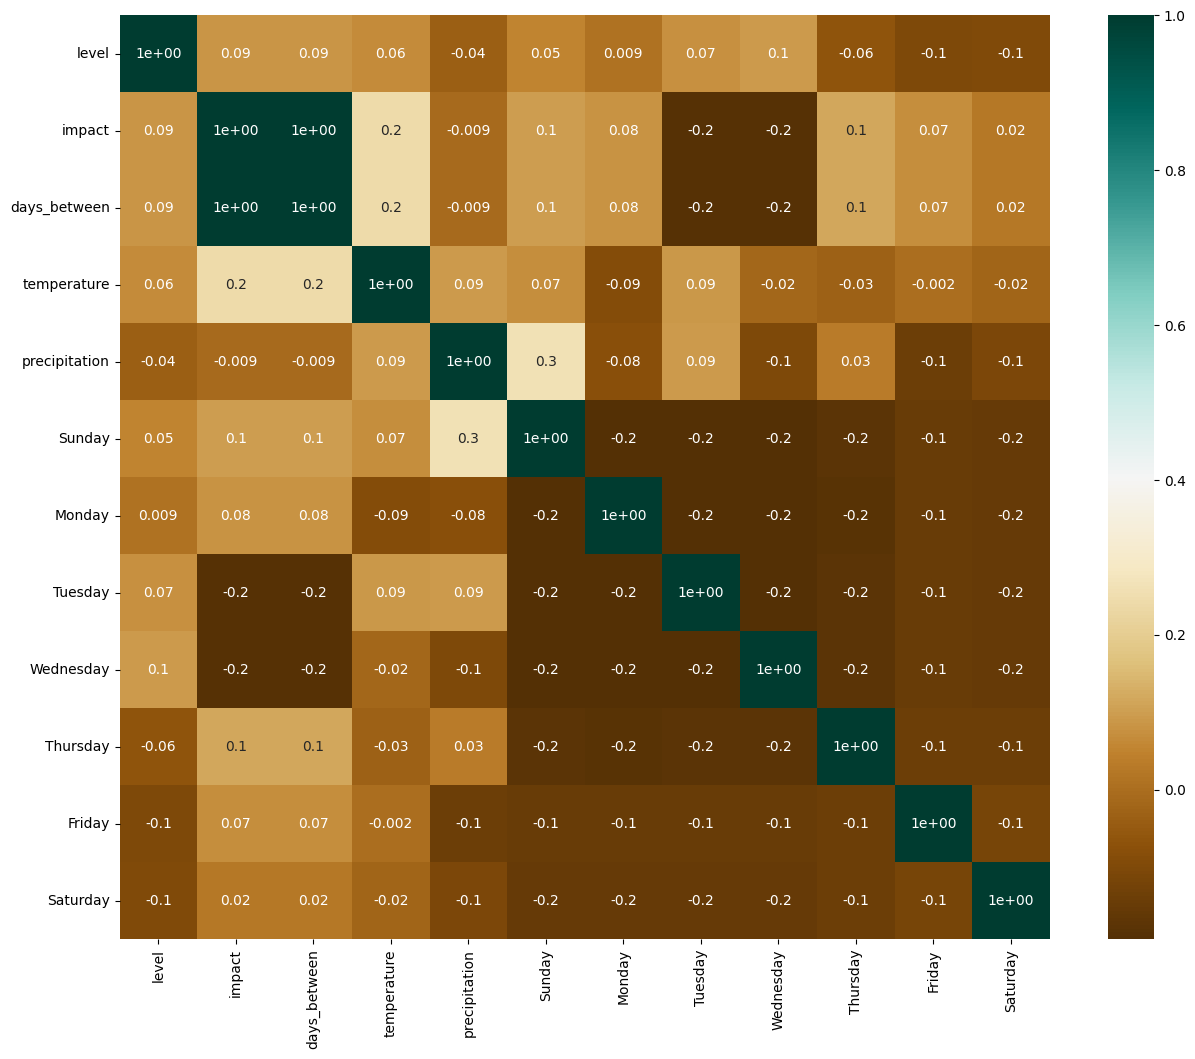

In [217]:
plt.figure(figsize=(15,12))
sns.heatmap(data=cor_spearman, annot=True, cmap = plt.cm.BrBG, fmt='.1')

#### Random Forest

##### Building the random forest

In [224]:
# preparing the data: selecting the features and target variable
data = lisbon_traffic[['impact', 'days_between', 'date', 'time', 'temperature', 'precipitation', 'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
target = lisbon_traffic['level']

# splitting the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size=0.2, random_state=15, shuffle=True, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=15, shuffle=True, stratify=y_train_val)

In [225]:
# building the random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=15)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=15)

In [226]:
# evaluate the model on the validation set
from sklearn.metrics import classification_report
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.98      0.99      0.99       342

    accuracy                           0.97       358
   macro avg       0.90      0.78      0.83       358
weighted avg       0.97      0.97      0.97       358



In [227]:
# the results were expected, as the data we used was very skewed, in the future we should this but with more data

In [228]:
# using the model to make predictions on the testing set
y_pred = rf.predict(X_test)

In [229]:
from sklearn.metrics import accuracy_score

# calculate accuracy score on training set
y_train_pred = rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# calculate accuracy score on testing set
y_test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

# compare the two scores
print('Training Accuracy:', train_acc)
print('Testing Accuracy:', test_acc)

Training Accuracy: 0.994413407821229
Testing Accuracy: 0.9776536312849162


## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

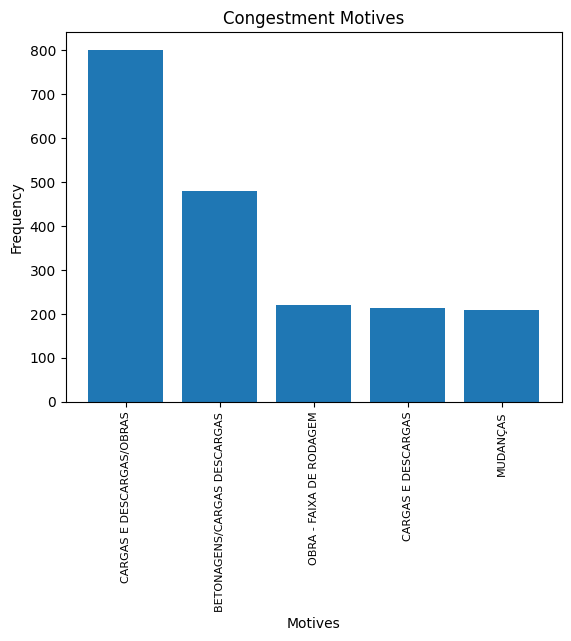

![image.png](
  
)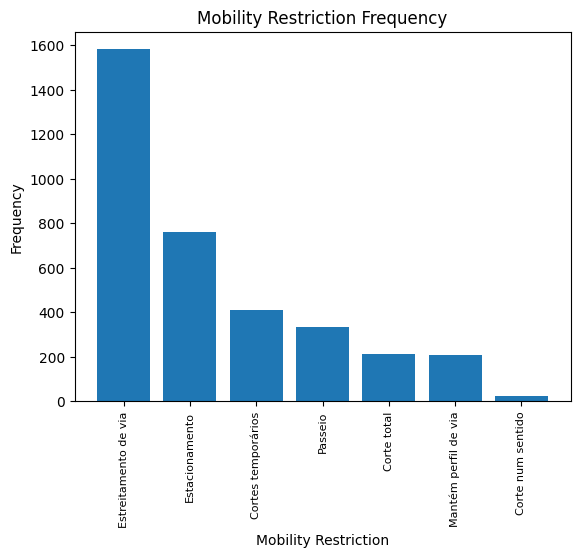

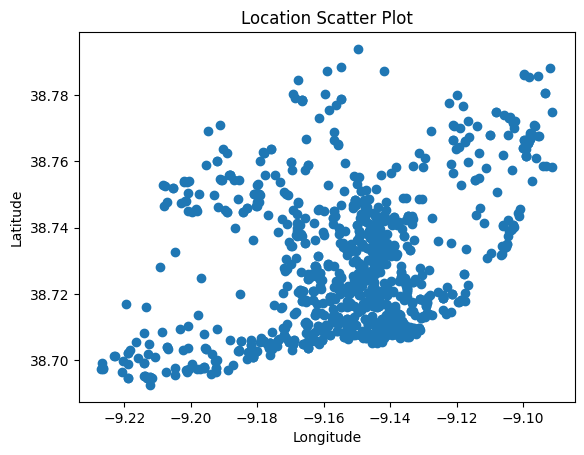

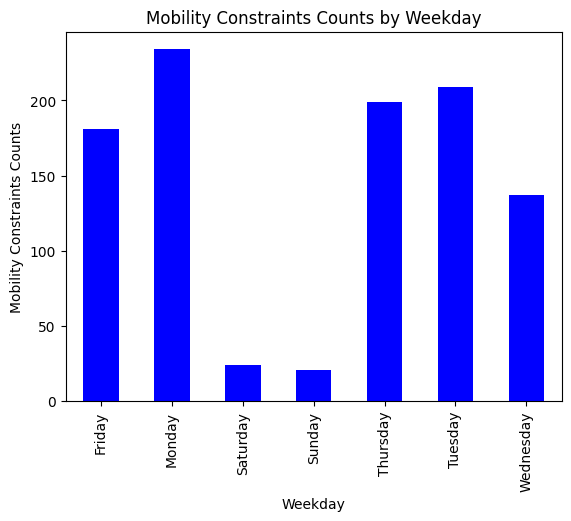

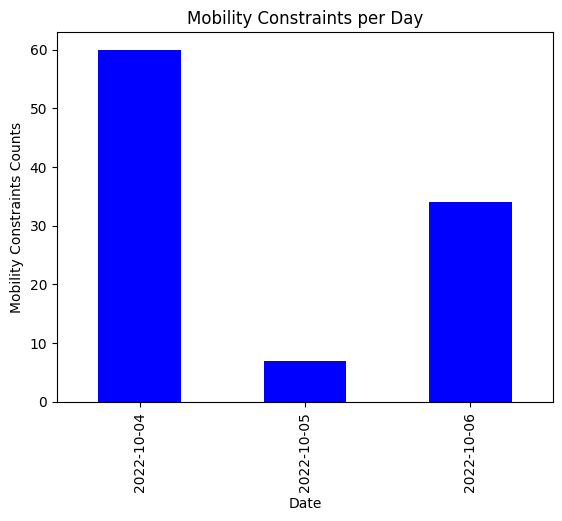

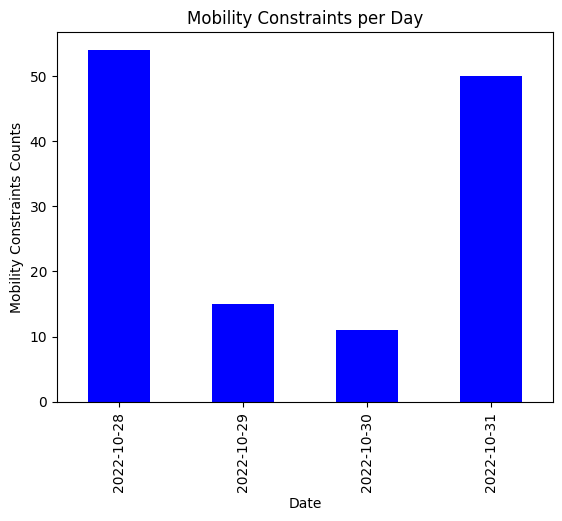

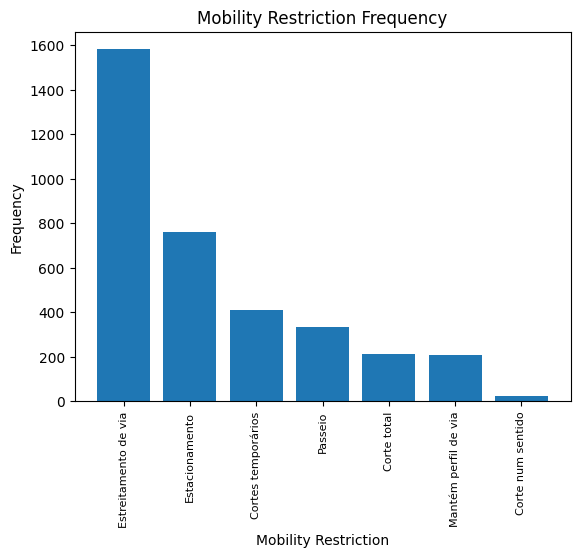

####Traffic in October in all of Lisbon

In [232]:
traffic_out.columns

Index(['entity_ts', 'entity_id', 'level', 'length', 'delay', 'speed',
       'longitude', 'latitude', 'geometry', 'Freguesia', 'Concelho'],
      dtype='object')

In [234]:
grafico = traffic_out[['entity_ts', 'latitude', 'longitude', 'level']]
grafico = grafico.dropna()
grafico.isna().sum()

entity_ts    0
latitude     0
longitude    0
level        0
dtype: int64

In [235]:
import matplotlib.gridspec as gridspec

# split the latitude and longitude values into separate columns
#grafico[['latitude', 'longitude']] = grafico['beginning'].str.split(',', expand=True)
#grafico_nov1[['end_latitude', 'end_longitude']] = grafico_nov1['end'].str.split(',', expand=True)

# convert the coordinates to floats
#grafico_nov1[['beginning_latitude', 'beginning_longitude', 'end_latitude', 'end_longitude']] = grafico_nov1[['beginning_latitude', 'beginning_longitude', 'end_latitude', 'end_longitude']].astype(float)


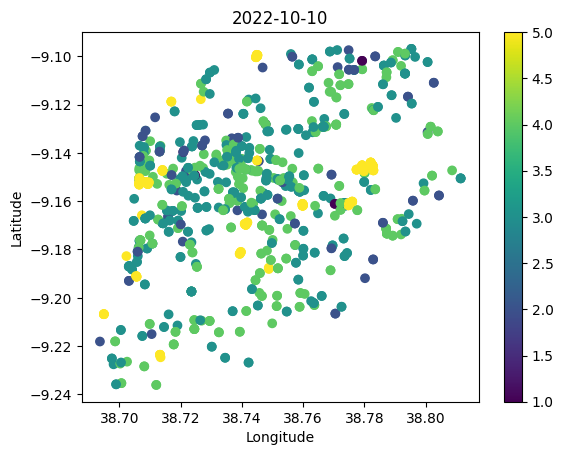

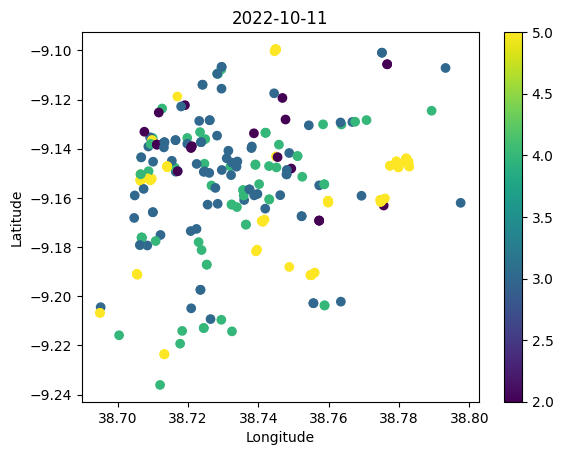

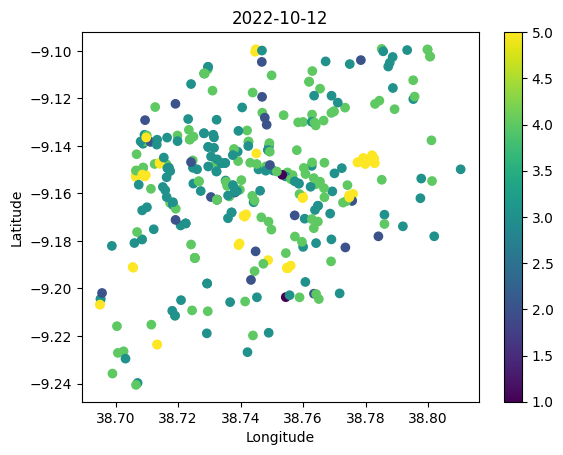

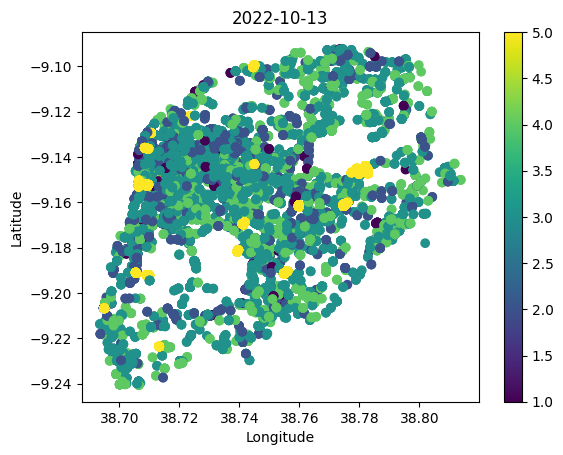

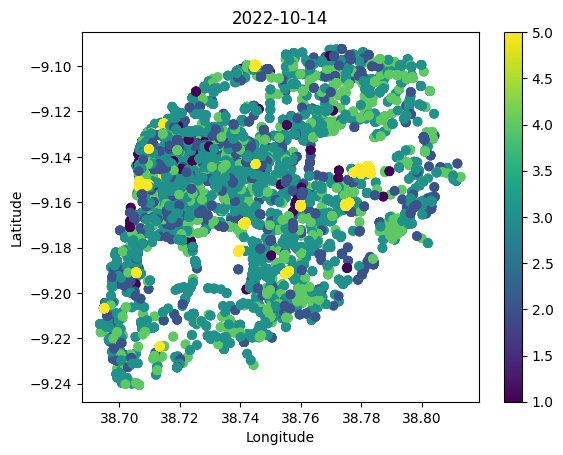

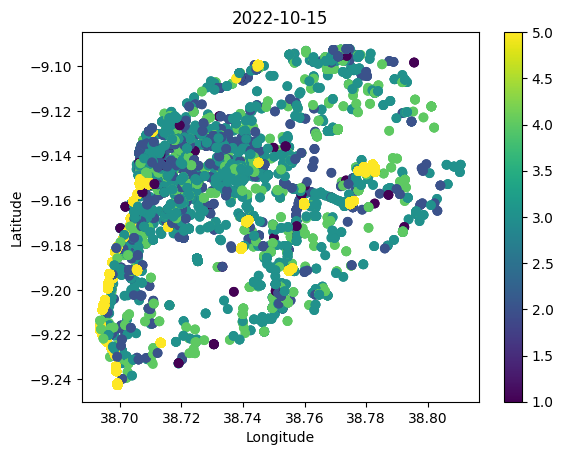

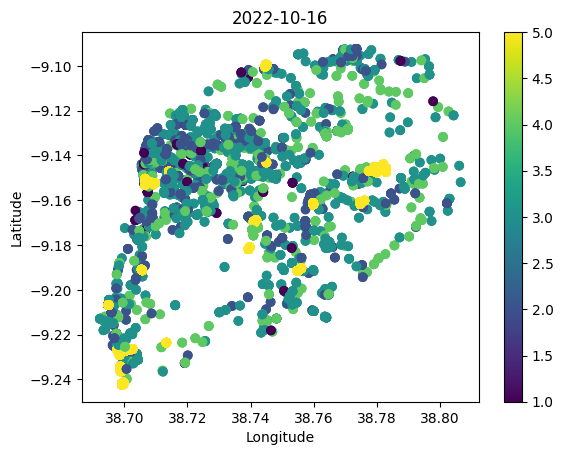

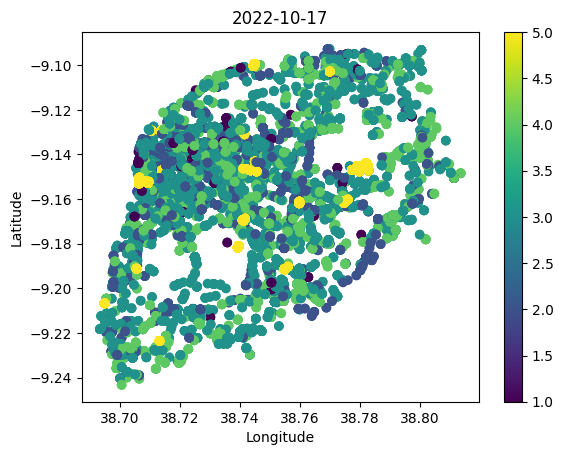

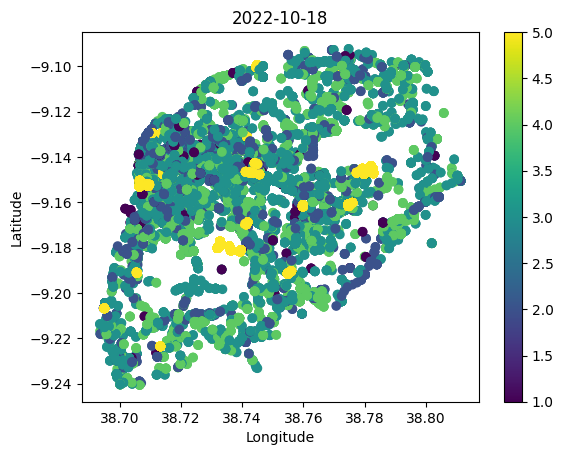

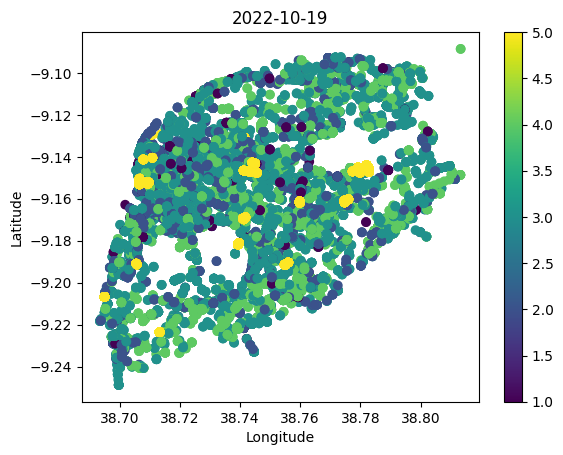

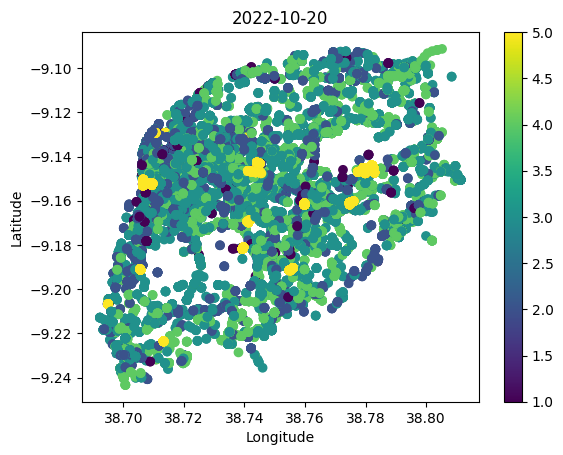

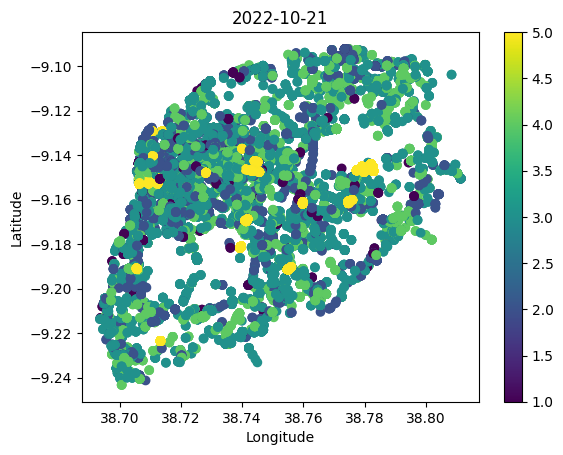

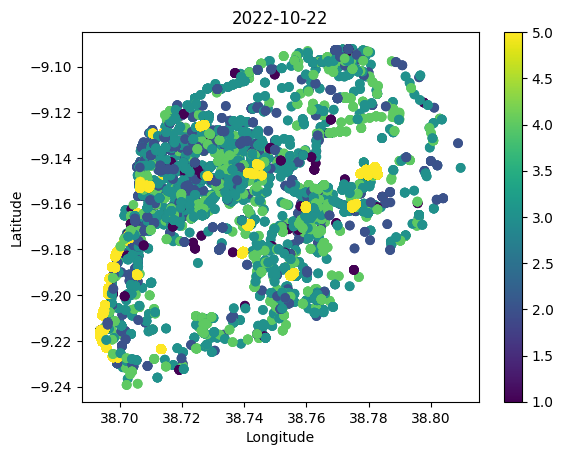

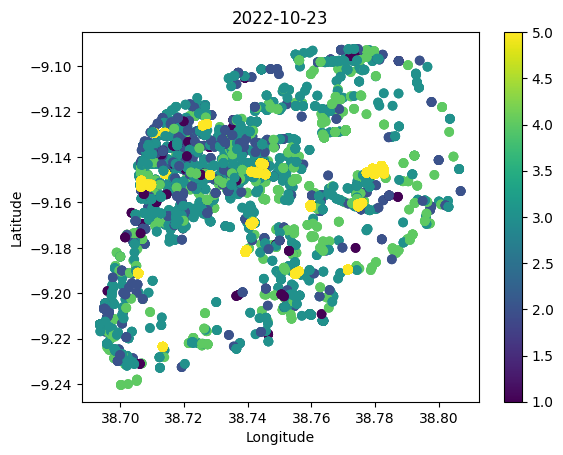

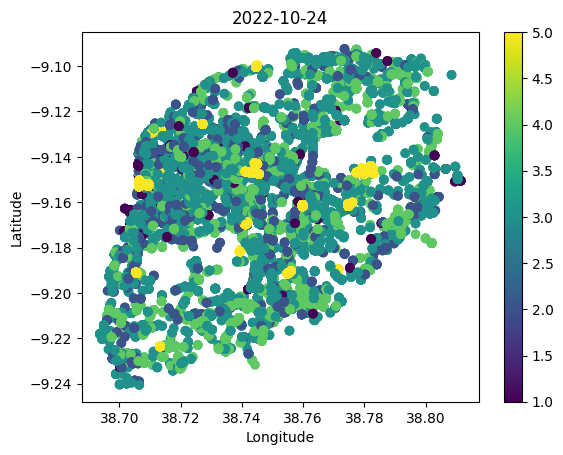

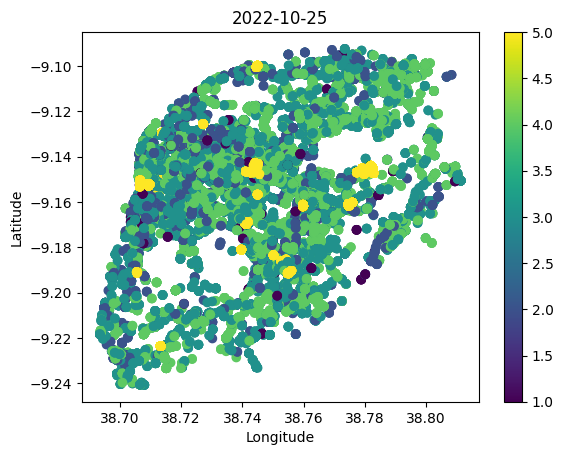

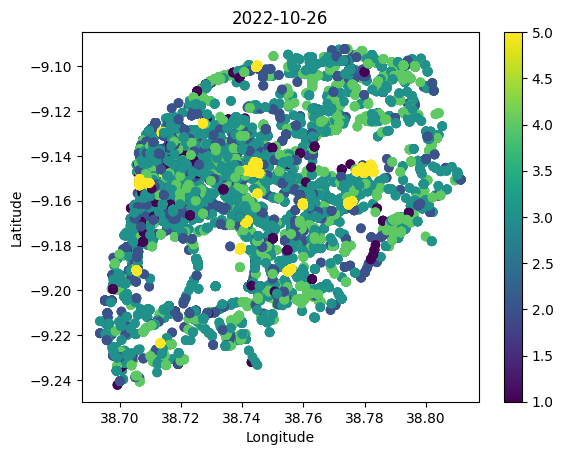

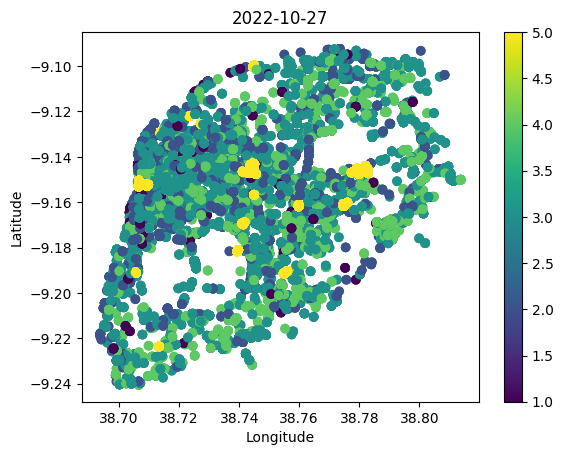

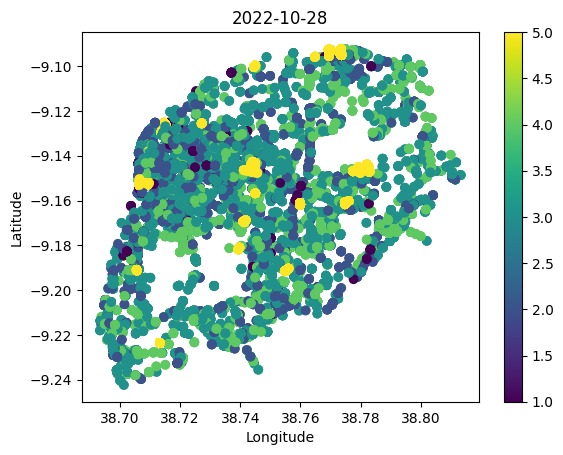

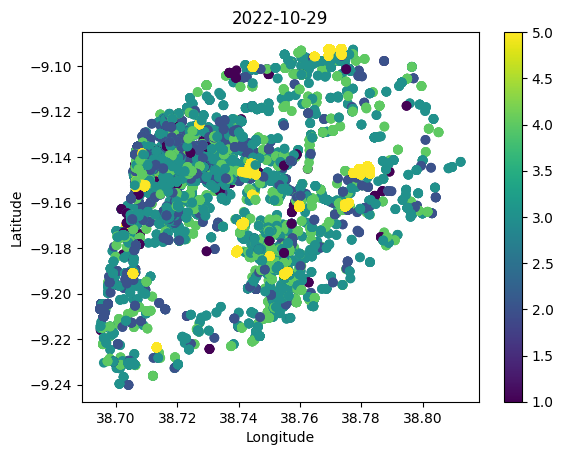

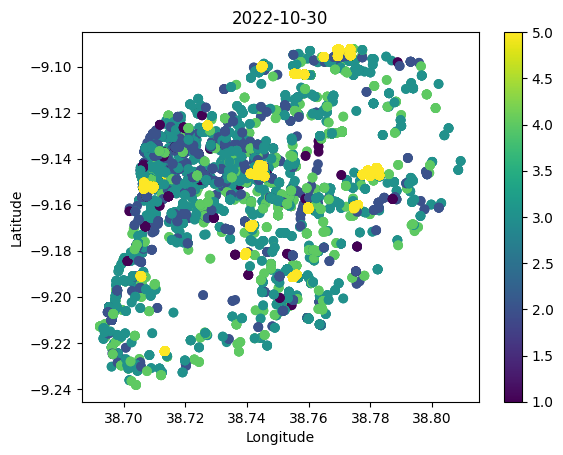

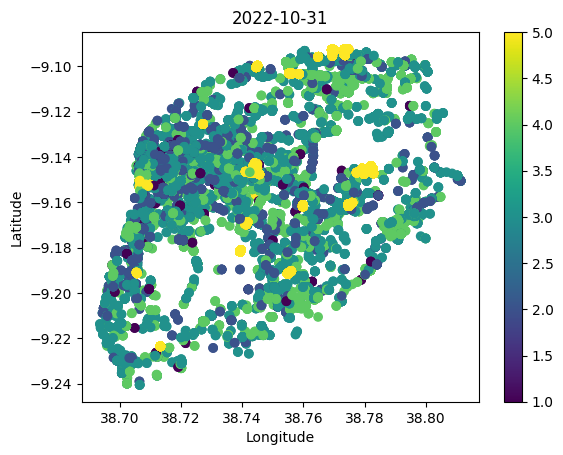

In [236]:
# Extract the date from the time column
grafico['date'] = grafico['entity_ts'].apply(lambda x: x.split('T')[0])

# Group the dataset by date and plot a scatter plot for each day
for date, group in grafico.groupby('date'):
    plt.scatter(group['latitude'], group['longitude'], c=group['level'], cmap='viridis')
    #plt.scatter(group['end_latitude'], group['end_longitude'], c=group['level'], cmap='viridis')
    plt.title(date)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    plt.show()

In [237]:
grafico.head(15)

,entity_ts,latitude,longitude,level,date
0,2022-10-10T07:19:21,38.811387,-9.150548,3.0,2022-10-10
1,2022-10-10T07:19:21,38.772525,-9.203698,3.0,2022-10-10
2,2022-10-10T07:19:21,38.714150,-9.169100,3.0,2022-10-10
3,2022-10-10T07:19:21,38.758415,-9.130084,3.0,2022-10-10
4,2022-10-10T07:19:21,38.786338,-9.103853,3.0,2022-10-10
5,2022-10-10T07:19:21,38.780044,-9.148354,4.0,2022-10-10
6,2022-10-10T07:19:21,38.780044,-9.148354,4.0,2022-10-10
7,2022-10-10T07:19:21,38.758415,-9.130084,3.0,2022-10-10
8,2022-10-10T07:19:21,38.714150,-9.169100,3.0,2022-10-10
9,2022-10-10T07:19:21,38.811387,-9.150548,3.0,2022-10-10


## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


####<font color='#BFD724'> 3. Merge Monthly Traffic Files

In [ ]:
# merging the september datasets and agregating the time in 15 min intervals
transito_set1_merge = transito_set1.copy()
transito_set1_merge['entity_ts'] = pd.to_datetime(transito_set1_merge['entity_ts'])
transito_set1_merge['time_15min'] = transito_set1_merge['entity_ts'].dt.round('15min')

transito_set2_merge = transito_set2.copy()
transito_set2_merge['entity_ts'] = pd.to_datetime(transito_set2_merge['entity_ts'])
transito_set2_merge['time_15min'] = transito_set2_merge['entity_ts'].dt.round('15min')

transito_set3_merge = transito_set3.copy()
transito_set3_merge['entity_ts'] = pd.to_datetime(transito_set3_merge['entity_ts'])
transito_set3_merge['time_15min'] = transito_set3_merge['entity_ts'].dt.round('15min')

transito_set4_merge = transito_set4.copy()
transito_set4_merge['entity_ts'] = pd.to_datetime(transito_set4_merge['entity_ts'])
transito_set4_merge['time_15min'] = transito_set4_merge['entity_ts'].dt.round('15min')

dataset_mean_set1 = transito_set1_merge.groupby('time_15min').mean()
dataset_mean_set2 = transito_set2_merge.groupby('time_15min').mean()
dataset_mean_set3 = transito_set3_merge.groupby('time_15min').mean()
dataset_mean_set4 = transito_set4_merge.groupby('time_15min').mean()

##############################

df_traffic['date_max'] = pd.to_datetime(df_traffic['date_max'])
df_traffic['date_min'] = pd.to_datetime(df_traffic['date_min'])

df_traffic['creation_date'] = pd.to_datetime(df_traffic['creation_date'])
df_traffic['time_15min'] = df_traffic['creation_date'].dt.round('15min')

df_traffic_mean = df_traffic.groupby('time_15min').sum()

##############################

"""merged_set1 = pd.merge(dataset_mean_set1, df_traffic_mean, on='time_15min', how='inner')
merged_set2 = pd.merge(dataset_mean_set2, df_traffic_mean, on='time_15min', how='inner')
merged_set3 = pd.merge(dataset_mean_set3, df_traffic_mean, on='time_15min', how='inner')
merged_set4 = pd.merge(dataset_mean_set4, df_traffic_mean, on='time_15min', how='inner')"""

if df_traffic.empty:
    print('df_traffic is empty')
else:
  merged_set1= dataset_mean_set1.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
      'level': 'mean', 
      'length': 'mean', 
      'delay': 'mean', 
      'speed': 'mean', 
      'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None, 
      #'impact': 'mean',
      'latitude': 'mean', 
      'longitude': 'mean', 
      'date_min': 'first', 
      'date_max': 'first', 
      'days_between': 'mean',
  })

merged_set2= dataset_mean_set2.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

merged_set3= dataset_mean_set3.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

merged_set4= dataset_mean_set4.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

In [ ]:
transito_out1_merge = transito_out1.copy()
transito_out1_merge['entity_ts'] = pd.to_datetime(transito_out1_merge['entity_ts'])
transito_out1_merge['time_15min'] = transito_out1_merge['entity_ts'].dt.round('15min')

transito_out2_merge = transito_out2.copy()
transito_out2_merge['entity_ts'] = pd.to_datetime(transito_out2_merge['entity_ts'])
transito_out2_merge['time_15min'] = transito_out2_merge['entity_ts'].dt.round('15min')

dataset_mean_out1 = transito_out1_merge.groupby('time_15min').mean()
dataset_mean_out2 = transito_out2_merge.groupby('time_15min').mean()

#######################################

#merged_out1 = pd.merge(dataset_mean_out1, df_traffic_mean, on='time_15min', how='inner')
#merged_out2 = pd.merge(dataset_mean_out2, df_traffic_mean, on='time_15min', how='inner')

merged_out1= dataset_mean_out1.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

merged_out2= dataset_mean_out2.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None, 
    'latitude': 'mean', 
    'longitude': 'mean',  
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})


In [ ]:
transito_nov1_merge = transito_nov1.copy()
transito_nov1_merge['entity_ts'] = pd.to_datetime(transito_nov1_merge['entity_ts'])
transito_nov1_merge['time_15min'] = transito_nov1_merge['entity_ts'].dt.round('15min')

transito_nov2_merge = transito_nov2.copy()
transito_nov2_merge['entity_ts'] = pd.to_datetime(transito_nov2_merge['entity_ts'])
transito_nov2_merge['time_15min'] = transito_nov2_merge['entity_ts'].dt.round('15min')

transito_nov3_merge = transito_nov3.copy()
transito_nov3_merge['entity_ts'] = pd.to_datetime(transito_nov3_merge['entity_ts'])
transito_nov3_merge['time_15min'] = transito_nov3_merge['entity_ts'].dt.round('15min')

dataset_mean_nov1 = transito_nov1_merge.groupby('time_15min').mean()
dataset_mean_nov2 = transito_nov2_merge.groupby('time_15min').mean()
dataset_mean_nov3 = transito_nov3_merge.groupby('time_15min').mean()

##############################

#merged_nov1 = pd.merge(dataset_mean_nov1, df_traffic_mean, on='time_15min', how='inner')
#merged_nov2 = pd.merge(dataset_mean_nov2, df_traffic_mean, on='time_15min', how='inner')
#merged_nov3 = pd.merge(dataset_mean_nov3, df_traffic_mean, on='time_15min', how='inner')

merged_nov1= dataset_mean_nov1.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean',
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

merged_nov2= dataset_mean_nov2.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})

merged_nov3= dataset_mean_nov3.merge(df_traffic, on='time_15min', how='left').groupby('time_15min').agg({
    'level': 'mean', 
    'length': 'mean', 
    'delay': 'mean', 
    'speed': 'mean', 
    'impact': lambda x: x.mode().iat[0] if not x.mode().empty else None,  
    'latitude': 'mean', 
    'longitude': 'mean', 
    'date_min': 'first', 
    'date_max': 'first', 
    'days_between': 'mean',
})


#### Regression

In [ ]:
# Select the best features
X_traffic = lisbon_traffic.loc[:, lisbon_traffic.columns != 'level']
y_traffic = lisbon_traffic['level']

#X_traffic['date_min'] = X_traffic['date_min'].astype(int) // 10**9
#X_traffic['date_max'] = X_traffic['date_max'].astype(int) // 10**9

import datetime

#X_traffic['date_max'] = X_traffic['date_max'].apply(lambda x: x.strftime('%Y%m%d'))
X_traffic.loc[~X_traffic['date_max'].isna(), 'date_max'] = X_traffic.loc[~X_traffic['date_max'].isna(), 'date_max'].apply(lambda x: x.strftime('%Y%m%d'))
#X_traffic['date_min'] = X_traffic['date_min'].apply(lambda x: x.strftime('%Y%m%d'))
X_traffic.loc[~X_traffic['date_min'].isna(), 'date_min'] = X_traffic.loc[~X_traffic['date_min'].isna(), 'date_min'].apply(lambda x: x.strftime('%Y%m%d'))

X_traffic['time_15min'] = pd.to_datetime(X_traffic['time_15min'])
X_traffic['time_15min'] = X_traffic['time_15min'].dt.strftime('%Y%m%d%H%M%S')

#X_train_val['date_max'] = X_train_val['date_max'].apply(lambda x: x.strftime('%Y%m%d'))
X_train_val.loc[~X_train_val['date_max'].isna(), 'date_max'] = X_train_val.loc[~X_train_val['date_max'].isna(), 'date_max'].apply(lambda x: x.strftime('%Y%m%d'))
#X_train_val['date_min'] = X_train_val['date_min'].apply(lambda x: x.strftime('%Y%m%d'))
X_train_val.loc[~X_train_val['date_min'].isna(), 'date_min'] = X_train_val.loc[~X_train_val['date_min'].isna(), 'date_min'].apply(lambda x: x.strftime('%Y%m%d'))

X_train_val['time_15min'] = pd.to_datetime(X_train_val['time_15min'])
X_train_val['time_15min'] = X_train_val['time_15min'].dt.strftime('%Y%m%d%H%M%S')


In [ ]:
y_train_val.head()

In [ ]:
"""anova = SelectKBest(f_classif, k=5)

X_anova = anova.fit_transform(X_traffic, y_traffic)

selected_features = pd.Series(anova.get_support(), index=X_traffic.columns)
selected_features

# Train the logistic regression model
log_model = LinearRegression()
log_model.fit(X_train_val, y_train_val)
y_pred = log_model.predict(X_test)

# Evaluate the model
log_model.score(X_train, y_train)

# Define the validation data and evaluate the model
log_model.score(X_val, y_val)

confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

# Evaluate the model again on both training and validation sets
log_model.score(X_train_val, y_train_val)
log_model.score(X_val, y_val)"""

In [ ]:
"""anova = SelectKBest(f_classif, k=5)

X_anova = anova.fit_transform(X_traffic, y_traffic)

selected_features = pd.Series(anova.get_support(), index=X_traffic.columns)
selected_features

# Train the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train_val, y_train_val)
y_pred = lin_model.predict(X_test)

# Evaluate the model using mean squared error (MSE) and root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error, r2_score

print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error (RMSE): %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-squared (R2): %.2f' % r2_score(y_test, y_pred))

# Define the validation data and evaluate the model
print('Validation R-squared (R2): %.2f' % lin_model.score(X_val, y_val))"""

In [ ]:
import json

#dataset['longitude'] = json.loads(pd.Series(dataset['position']))['geometries'][0]
transito_nov1['position'] = transito_nov1['position'].astype(str)

#df = pd.DataFrame(dataset['position'].apply(lambda x: pd.DataFrame(json.loads(x)['geometries'][0]['coordinates'][0])).values.tolist(), columns=['longitude', 'latitude'])

position_data = transito_nov1['position'].str.split('[', expand=True)

transito_nov1['beginning'] = position_data[4].astype(str)
position_lon = transito_nov1['beginning'].str.split(']', expand=True)
transito_nov1['beginning'] = position_lon[0].astype(str)

transito_nov1['end'] = position_data[5].astype(str)
position_lat = transito_nov1['end'].str.split(']', expand=True)
transito_nov1['end'] = position_lat[0].astype(str)

####delete

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive', force_remount=True)

transito_set1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze1.csv')
transito_set2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze2.csv')
transito_set3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze3.csv')
transito_set4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_set_waze4.csv')"""

In [ ]:
"""transito_out1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_out_waze1.csv')
transito_out2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_out_waze2.csv')"""

In [ ]:
"""transito_nov1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze1.csv')
transito_nov2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze2.csv')
transito_nov3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/transito_nov_waze3.csv')"""

In [ ]:
import os
os.getcwd()

In [ ]:
dataset2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv')
dataset3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/entrada_saida_mainRoads_15min.csv')
dataset2.head(5)

In [ ]:
dataset3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study/data/entrada_saida_mainRoads_15min.csv')

dataset3.head(5)

In [ ]:
dataset3['Eixo'].value_counts()

###old merge

In [ ]:
"""transito_set1_merge = transito_set1.copy()
transito_set1_merge['entity_ts'] = pd.to_datetime(transito_set1_merge['entity_ts'])
transito_set1_merge['time_15min'] = transito_set1_merge['entity_ts'].dt.round('15min')

transito_set2_merge = transito_set2.copy()
transito_set2_merge['entity_ts'] = pd.to_datetime(transito_set2_merge['entity_ts'])
transito_set2_merge['time_15min'] = transito_set2_merge['entity_ts'].dt.round('15min')

transito_set3_merge = transito_set3.copy()
transito_set3_merge['entity_ts'] = pd.to_datetime(transito_set3_merge['entity_ts'])
transito_set3_merge['time_15min'] = transito_set3_merge['entity_ts'].dt.round('15min')

transito_set4_merge = transito_set4.copy()
transito_set4_merge['entity_ts'] = pd.to_datetime(transito_set4_merge['entity_ts'])
transito_set4_merge['time_15min'] = transito_set4_merge['entity_ts'].dt.round('15min')

dataset_mean_set1 = transito_set1_merge.groupby('time_15min').median()
dataset_mean_set2 = transito_set2_merge.groupby('time_15min').median()
dataset_mean_set3 = transito_set3_merge.groupby('time_15min').median()
dataset_mean_set4 = transito_set4_merge.groupby('time_15min').median()

##############################

dataset2['creation_date'] = pd.to_datetime(dataset2['creation_date'])
dataset2['time_15min'] = dataset2['creation_date'].dt.round('15min')

dataset2_mean = dataset2.groupby('time_15min').median()

##############################

merged_set1 = pd.merge(dataset_mean_set1, dataset2_mean, on='time_15min', how='inner')
merged_set2 = pd.merge(dataset_mean_set2, dataset2_mean, on='time_15min', how='inner')
merged_set3 = pd.merge(dataset_mean_set3, dataset2_mean, on='time_15min', how='inner')
merged_set4 = pd.merge(dataset_mean_set4, dataset2_mean, on='time_15min', how='inner')
#merged = pd.merge(transito_set1_merge, dataset2, on='hour', how='inner')
#merged_set1.head(5)"""



In [ ]:
"""transito_out1_merge = transito_out1.copy()
transito_out1_merge['entity_ts'] = pd.to_datetime(transito_out1_merge['entity_ts'])
transito_out1_merge['time_15min'] = transito_out1_merge['entity_ts'].dt.round('15min')

transito_out2_merge = transito_out2.copy()
transito_out2_merge['entity_ts'] = pd.to_datetime(transito_out2_merge['entity_ts'])
transito_out2_merge['time_15min'] = transito_out2_merge['entity_ts'].dt.round('15min')

dataset_mean_out1 = transito_out1_merge.groupby('time_15min').mean()
dataset_mean_out2 = transito_out2_merge.groupby('time_15min').mean()

#######################################

merged_out1 = pd.merge(dataset_mean_out1, dataset2_mean, on='time_15min', how='inner')
merged_out2 = pd.merge(dataset_mean_out2, dataset2_mean, on='time_15min', how='inner')
#merged = pd.merge(transito_out1_merge, dataset2, on='hour', how='inner')
#merged_out1.head(5)"""

In [ ]:
"""transito_nov1_merge = transito_nov1.copy()
transito_nov1_merge['entity_ts'] = pd.to_datetime(transito_nov1_merge['entity_ts'])
transito_nov1_merge['time_15min'] = transito_nov1_merge['entity_ts'].dt.round('15min')

transito_nov2_merge = transito_nov2.copy()
transito_nov2_merge['entity_ts'] = pd.to_datetime(transito_nov2_merge['entity_ts'])
transito_nov2_merge['time_15min'] = transito_nov2_merge['entity_ts'].dt.round('15min')

transito_nov3_merge = transito_nov3.copy()
transito_nov3_merge['entity_ts'] = pd.to_datetime(transito_nov3_merge['entity_ts'])
transito_nov3_merge['time_15min'] = transito_nov3_merge['entity_ts'].dt.round('15min')

dataset_mean_nov1 = transito_nov1_merge.groupby('time_15min').mean()
dataset_mean_nov2 = transito_nov2_merge.groupby('time_15min').mean()
dataset_mean_nov3 = transito_nov3_merge.groupby('time_15min').mean()

##############################

merged_nov1 = pd.merge(dataset_mean_nov1, dataset2_mean, on='time_15min', how='inner')
merged_nov2 = pd.merge(dataset_mean_nov2, dataset2_mean, on='time_15min', how='inner')
merged_nov3 = pd.merge(dataset_mean_nov3, dataset2_mean, on='time_15min', how='inner')
#merged = pd.merge(transito_nov1_merge, dataset2, on='hour', how='inner')
#merged_nov1.head(5)"""


#### Visualizations